# Разведывательный анализ данных учащихся

## Цель проекта:
Отследить **влияние условий жизни** учащихся в возрасте от 15 до 22 лет **на их успеваемость по математике**, что позволит на ранней стадии выявлять студентов, находящихся в группе риска.

## Задачи проекта:
1. Провести **разведывательный анализ данных (EDA)**:
    - _проверить качество данных_ и очистить их при необходимости;
    - _сформулировать предположения_ для дальнейшего построения модели;
    - _определиться с параметрами модели_, оказывающими влияние на целевой показатель (успеваемость по математике).
2. Построить модель, предсказывающую результаты госэкзамена по математике для каждого ученика школы.

В рамках данного подпроекта решалась только **первая задача**. 

### Импорт библиотек и модулей, настройка отображения значений

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import math 

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import norm
from random import random

import mod_eda # импортируем модуль с созданными функциями проведения EDA

# Настроим вывод графиков и таблиц
sns.set()

pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 50) # выведем больше колонок

### Функции отображения значений

In [2]:
# Функция отображения состава КАТЕГОРИАЛЬНОЙ КОЛОНКИ
def display_cat_compos(df, column, disp=True, plot=True, rot=0):

    answer_dict = {
        'nulls': {},
        'df': ''
    }

    # Имеются ли None-элементы или пробельные пропуски
    nulls_dict = mod_eda.find_nulls(df[column])
    answer_dict['nulls'] = nulls_dict

    # Оценим состав данной колонки
    answer_dict['df'] = pd.DataFrame({'total': df[column].value_counts(), 
                        'proportion': df[column].value_counts(normalize=True)})
    
    # ВЫВОД РЕЗУЛЬТАТОВ АНАЛИЗА КОЛОНКИ
    if disp:
        # Данные по Null:
        if nulls_dict['skip_nan'] == 0:
            print('None-пропуски отсутствуют.')
        else:
            print(f"Количество None-пропусков: {nulls_dict['skip_nan']}")
        
        if nulls_dict['skip_space'] == 0:
            print('Пробельные пропуски отсутствуют.')
        else:
            print(f"Количество пробельных пропусков: {nulls_dict['skip_space']}")        
    
        if nulls_dict['frac_skips'] > 0:
            print(f"\nДоля пропусков от объёма выборки: {round(nulls_dict['frac_skips']*100, 1)}%")

        # Вывод датафрейма
        print('\nСостав колонки ' + column)
        display(answer_dict['df'])
    
    if plot:
        #Построим распределение
        df[column].value_counts(normalize=True).plot(kind='bar',
                                                        grid= True,
                                                        title=column + " proportion",
                                                        legend=False) 
        plt.xticks(rotation=rot)
    
    return answer_dict

In [3]:
# Функция отображения состава ЧИСЛОВОЙ КОЛОНКИ
def display_num_compos(df, column, disp=True, plot=True, bin_koef=1):
    answer_dict = {
        'nulls': {},
        'df': '',
        'outliers': ''
    }    
    
    # Имеются ли None-элементы или пробельные пропуски
    nulls_dict = mod_eda.find_nulls(df[column])
    answer_dict['nulls'] = nulls_dict

    # Статистическое описание колонки
    answer_dict['df'] = pd.DataFrame(df[column].describe())  
    
    # Определим границы выбросов, и выведем данные, соответствующие этому диапазону в гистограмму
    boards = mod_eda.get_boards(df[column])

    # Значение и количество выбросов
    out_ser = df[(df[column] > boards[1])| \
                                (df[column] < boards[0])][column]
    answer_dict['outliers'] = pd.DataFrame({'outliers_count': out_ser.value_counts()})

    # ВЫВОД РЕЗУЛЬТАТОВ АНАЛИЗА КОЛОНКИ
    if disp:
        # Данные по Null:
        if nulls_dict['skip_nan'] == 0:
            print('None-пропуски отсутствуют.')
        else:
            print(f"Количество None-пропусков: {nulls_dict['skip_nan']}")
        
        if nulls_dict['skip_space'] == 0:
            print('Пробельные пропуски отсутствуют.')
        else:
            print(f"Количество пробельных пропусков: {nulls_dict['skip_space']}")        
    
        if nulls_dict['frac_skips'] > 0:
            print(f"\nДоля пропусков от объёма выборки: {round(nulls_dict['frac_skips']*100, 1)}%")

        # Вывод датафрейма c статистическим описанием колонки
        print('\nСтатистические характеристики колонки ' + column)
        display(answer_dict['df'])
        
        # Вывод данных по выбросам
        if len(answer_dict['outliers']) > 0:
            print(f"\nКоличество выбросов: {answer_dict['outliers']['outliers_count'].sum()}")
            print("\nЗначения выбросов:")
            display(answer_dict['outliers'])
        else:
            print("\nВыбросы не обнаружены")

    if plot:
        # Построение графиков в одном месте
        fig, axes = plt.subplots(1,2, figsize=(16,6))
        # Построение boxplot
        sns.boxplot(df[column],ax=axes[0])
        axes[0].set_title(column+' boxplot') 

        # Построение распределение признака
        
        # Датафрейм, содержащий значения в границах выбросов
        iqr_ser = df[df[column].between(boards[0], boards[1])][column]
        # Диапазон фактических значений датафрейма
        board_iqr = int(iqr_ser.value_counts().index.max() - iqr_ser.value_counts().index.min())
    
        axes[1].set_title(column + ' hist')

        # Построение гистограммы значений без выбросов
        axes[1].hist(iqr_ser, bins=int(board_iqr/bin_koef), label='IQR')
        
        # Выбросы
        if len(answer_dict['outliers']) > 0:
            axes[1].hist(out_ser, bins=len(answer_dict['outliers']), color='red', label='outliers')
            plt.legend()

    return answer_dict

In [4]:
# Функция отображения ВЗАИМОСВЯЗИ между колонками
def display_col_relation(df, column, sub_column_list, compos=[]):
    answer_list = []
    for sub_column in sub_column_list:
        sub_answer_dict = {
            'sub_column': sub_column,
            'crosstab': pd.crosstab(df[column], df[sub_column], normalize='columns'),
            'both_nones': len(df[(df[column].isna())&(df[sub_column].isna())]),
            'struct_nones': pd.DataFrame(df[df[column].isna()][sub_column].value_counts(normalize=True))
        }
        answer_list.append(sub_answer_dict)
    
    # ВЫВОД
    
    if len(compos) > 0:
        #Повторный вывод состава колонки
        print(f'\nСостав колонки {column}')
        display(compos['df'])

    for i, elem in enumerate(answer_list):
        print('\n')
        print(f"\n{i+1}) Распределение значений колонки {elem['sub_column']} по значениям изучаемой колонки {column}")
        display(elem['crosstab'])
        
        print(f"\nКоличество строк с пропусками в обеих колонках: {elem['both_nones']}")
        
        print(f"\nСостав для None-значений изучаемой колонки {column} по значениям колонки {elem['sub_column']}")
        display(elem['struct_nones'])
    
    return answer_list

## Первичный осмотр данных

In [5]:
# Загрузим исходный датасет и рассмотрим его
stud = pd.read_csv('stud_math.csv')
display(stud.head(10))
stud.info()

school sex  age address famsize Pstatus  Medu  Fedu      Mjob     Fjob  \
0     GP   F   18       U     NaN       A   4.0   4.0   at_home  teacher   
1     GP   F   17       U     GT3     NaN   1.0   1.0   at_home    other   
2     GP   F   15       U     LE3       T   1.0   1.0   at_home    other   
3     GP   F   15       U     GT3       T   4.0   2.0    health      NaN   
4     GP   F   16       U     GT3       T   3.0   3.0     other    other   
5     GP   M   16       U     LE3       T   4.0   3.0  services    other   
6     GP   M   16     NaN     LE3       T   2.0   2.0     other    other   
7     GP   F   17       U     GT3       A   4.0   4.0     other  teacher   
8     GP   M   15       U     LE3       A   3.0   2.0  services    other   
9     GP   M   15       U     NaN     NaN   3.0   4.0     other    other   

       reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0      course   mother         2.0        2.0       0.0       yes     no   no   
1      course   father         1.0        2.0       0.0        no    yes   no   
2       other   mother         1.0        2.0       3.0       yes     no  NaN   
3        home   mother         1.0        3.0       0.0        no    yes  yes   
4        home   father         1.0        2.0       0.0        no    yes  yes   
5  reputation   mother         1.0        2.0       0.0        no    yes  yes   
6        home   mother         1.0        2.0       0.0        no     no   no   
7        home   mother         2.0        2.0       0.0       yes    yes   no   
8        home   mother         1.0        2.0       0.0        no    yes  yes   
9        home   mother         1.0        2.0       0.0        no    yes  yes   

  activities nursery  studytime, granular higher internet romantic  famrel  \
0         no     yes                 -6.0    yes      NaN       no     4.0   
1         no      no                 -6.0    yes      yes       no     5.0   
2         no     yes                 -6.0    yes      yes      NaN     4.0   
3        yes     yes                 -9.0    yes      yes      yes     3.0   
4         no     yes                 -6.0    yes       no       no     4.0   
5        yes     yes                 -6.0    yes      yes       no     5.0   
6         no     yes                 -6.0    yes      yes       no     4.0   
7         no     yes                 -6.0    yes       no       no     4.0   
8         no     yes                 -6.0    yes      yes       no     NaN   
9        yes     yes                 -6.0    yes      yes       no     5.0   

   freetime  goout  health  absences  score  
0       3.0    4.0     3.0       6.0   30.0  
1       3.0    3.0     3.0       4.0   30.0  
2       3.0    2.0     3.0      10.0   50.0  
3       2.0    2.0     5.0       2.0   75.0  
4       3.0    2.0     5.0       4.0   50.0  
5       4.0    2.0     5.0      10.0   75.0  
6       4.0    4.0     3.0       0.0   55.0  
7       1.0    4.0     1.0       6.0   30.0  
8       2.0    2.0     1.0       0.0   95.0  
9       5.0    1.0     5.0       0.0   75.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Первичный осмотр данных позволяет сделать вывод о том, что только *первые 3 колонки без пропусков*: "school", "sex", "age". 

В распоряжении имеются *30* колонок, из них *13* - **условно числовых** (хотя истинно **числовых** только *3-4*: "age", "absences", "score" и "failures", остальные **ранговые**), *17* - **категориальных** (*8* из них потенциально можно превратить в бинарный тип).  

Также первичный осмотр данных показал, что часть колонок названы с большой буквы (с целью отделения одного слова от другого). Есть также одна колонка "studytime, granular" имеющая название, написанное через запятую. 

Приведём колонки к стилю написания с маленькой буквы с отделением слов подчёркиванием.

In [6]:
stud.columns = ['school', 'sex', 'age', 'adress', 'famsize', 'p_status', 'm_edu', 'f_edu',
                'm_job', 'f_job', 'reason', 'guardian', 'traveltime', 'studytime',
                'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
                'freetime', 'goout', 'health_level', 'absences', 'score']
display(stud.head(10))

school sex  age adress famsize p_status  m_edu  f_edu     m_job    f_job  \
0     GP   F   18      U     NaN        A    4.0    4.0   at_home  teacher   
1     GP   F   17      U     GT3      NaN    1.0    1.0   at_home    other   
2     GP   F   15      U     LE3        T    1.0    1.0   at_home    other   
3     GP   F   15      U     GT3        T    4.0    2.0    health      NaN   
4     GP   F   16      U     GT3        T    3.0    3.0     other    other   
5     GP   M   16      U     LE3        T    4.0    3.0  services    other   
6     GP   M   16    NaN     LE3        T    2.0    2.0     other    other   
7     GP   F   17      U     GT3        A    4.0    4.0     other  teacher   
8     GP   M   15      U     LE3        A    3.0    2.0  services    other   
9     GP   M   15      U     NaN      NaN    3.0    4.0     other    other   

       reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0      course   mother         2.0        2.0       0.0       yes     no   no   
1      course   father         1.0        2.0       0.0        no    yes   no   
2       other   mother         1.0        2.0       3.0       yes     no  NaN   
3        home   mother         1.0        3.0       0.0        no    yes  yes   
4        home   father         1.0        2.0       0.0        no    yes  yes   
5  reputation   mother         1.0        2.0       0.0        no    yes  yes   
6        home   mother         1.0        2.0       0.0        no     no   no   
7        home   mother         2.0        2.0       0.0       yes    yes   no   
8        home   mother         1.0        2.0       0.0        no    yes  yes   
9        home   mother         1.0        2.0       0.0        no    yes  yes   

  activities nursery  studytime_granular higher internet romantic  famrel  \
0         no     yes                -6.0    yes      NaN       no     4.0   
1         no      no                -6.0    yes      yes       no     5.0   
2         no     yes                -6.0    yes      yes      NaN     4.0   
3        yes     yes                -9.0    yes      yes      yes     3.0   
4         no     yes                -6.0    yes       no       no     4.0   
5        yes     yes                -6.0    yes      yes       no     5.0   
6         no     yes                -6.0    yes      yes       no     4.0   
7         no     yes                -6.0    yes       no       no     4.0   
8         no     yes                -6.0    yes      yes       no     NaN   
9        yes     yes                -6.0    yes      yes       no     5.0   

   freetime  goout  health_level  absences  score  
0       3.0    4.0           3.0       6.0   30.0  
1       3.0    3.0           3.0       4.0   30.0  
2       3.0    2.0           3.0      10.0   50.0  
3       2.0    2.0           5.0       2.0   75.0  
4       3.0    2.0           5.0       4.0   50.0  
5       4.0    2.0           5.0      10.0   75.0  
6       4.0    4.0           3.0       0.0   55.0  
7       1.0    4.0           1.0       6.0   30.0  
8       2.0    2.0           1.0       0.0   95.0  
9       5.0    1.0           5.0       0.0   75.0

### Первоначальное описание колонок:
1 **school** — аббревиатура школы, в которой учится ученик;

2 **sex** — пол ученика (**'F'** - женский, **'M'** - мужской);

3 **age** — возраст ученика (от **15** до **22**);

4 **address** — тип адреса ученика (**'U'** - городской, **'R'** - за городом);

5 **famsize** — размер семьи(**'LE3'** <= 3, **'GT3'** >3);

6 **p_status** — статус совместного жилья родителей (**'T'** - живут вместе **'A'** - раздельно);

7 **m_edu** — образование матери (**0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее);

8 **f_edu** — образование отца (**0** - нет, **1** - 4 класса, **2** - 5-9 классы, 
    **3** - среднее специальное или 11 классов, **4** - высшее);

9 **m_job** — работа матери (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

10 **f_job** — работа отца (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **'services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

11 **reason** — причина выбора школы (**'home'** - близость к дому, **'reputation'** - репутация школы, 
    **'course'** - образовательная программа, **'other'** - другое);

12 **guardian** — опекун (**'mother'** - мать, **'father'** - отец, **'other'** - другое);

13 **traveltime** — время в пути до школы (**1** - <15 мин., **2** - 15-30 мин., 
    **3** - 30-60 мин., **4** - >60 мин.);

14 **studytime** — время на учёбу помимо школы в неделю (**1** - <2 часов, **2** - 2-5 часов, 
    **3** - 5-10 часов, **4** - >10 часов);

15 **failures** — количество внеучебных неудач (**n**, если 1<=n<3, иначе **4**);

16 **schoolsup** — дополнительная образовательная поддержка (**yes** или **no**);

17 **famsup** — семейная образовательная поддержка (**yes** или **no**);

18 **paid** — дополнительные платные занятия по математике (**yes** или **no**);

19 **activities** — дополнительные внеучебные занятия (**yes** или **no**);

20 **nursery** — посещал детский сад (**yes** или **no**);

**studytime_granular** - неизвестная колонка, необходимо понять, с чем она коррелирует

21 **higher** — хочет получить высшее образование (**yes** или **no**);

22 **internet** — наличие интернета дома (**yes** или **no**);

23 **romantic** — в романтических отношениях (**yes** или **no**);

24 **famrel** — семейные отношения (от **1** - очень плохо до **5** - очень хорошо);

25 **freetime** — свободное время после школы (от **1** - очень мало до **5** - очень мого);

26 **goout** — проведение времени с друзьями (от **1** - очень мало до **5** - очень много);

27 **health_level** — текущее состояние здоровья (от **1** - очень плохо до **5** - очень хорошо);

28 **absences** — количество пропущенных занятий;

29 **score** — баллы по госэкзамену по математике (целевой параметр).


In [7]:
# ОПРЕДЕЛЕНИЕ РАЗМЕРА ВЫБОРКИ
stud_count_total = len(stud)
print('\nОбщий размер выборки студентов:', stud_count_total)


Общий размер выборки студентов: 395


## Анализ данных в столбцах

### school
Аббревиатура школы, в которой учится ученик.

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки school


total  proportion
GP    349    0.883544
MS     46    0.116456

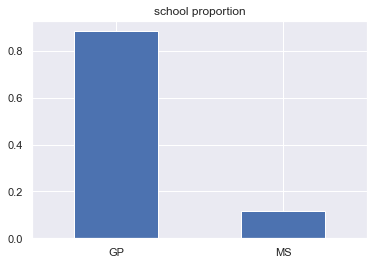

In [8]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'school'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'school'**: Пропуски в данном столбце отсутствуют. Около *88%* студентов выборки (общим размером *395* человек) обучаются в школе **"GP"**.  

### sex
Пол ученика: 'F' - женский, 'M' - мужской

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки sex


total  proportion
F    208    0.526582
M    187    0.473418

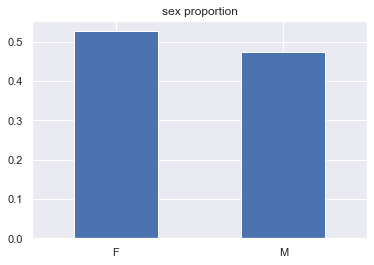

In [9]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'sex'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'sex'**: В данном столбце пропусков нет. Имеется небольшой **перевес**, порядка 5% **в пользу количества девочек** в выборке.

### age
Возраст ученика (от 15 до 22)

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Статистические характеристики колонки age


age
count  395.000000
mean    16.696203
std      1.276043
min     15.000000
25%     16.000000
50%     17.000000
75%     18.000000
max     22.000000


Количество выбросов: 1

Значения выбросов:


outliers_count
22               1

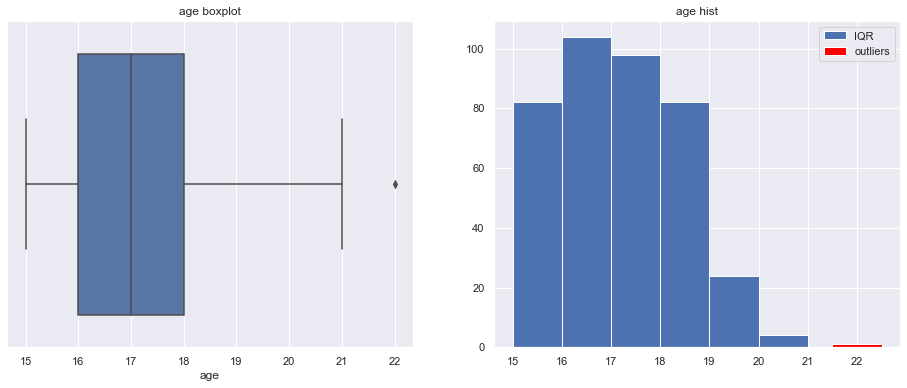

In [10]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ ЧИСЛОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'age'
# Вывод состава колонки
compos = display_num_compos(stud, column)

Оценим количество учеников от 19 лет и старше

In [11]:
stud[stud[column] > 18][column].value_counts()

19    24
20     3
22     1
21     1
Name: age, dtype: int64

Положим значение 20 лет для студентов в возрасте 20 лет и старше, чем устраним выброс в 22 года и исключим одиночное значение - 21 год.

In [12]:
stud['age'].replace([21,22], 20, inplace=True)

Создадим отдельно категориальную колонку для удобства анализа связи с другими колонками

In [13]:
stud[column+'_categ'] = mod_eda.change_num_to_count(stud, 'age', 3)
stud[column+'_categ'].value_counts()

(14.994, 16.667]    186
(16.667, 18.333]    180
(18.333, 20.0]       29
Name: age_categ, dtype: int64

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки age_categ


total  proportion
(14.994, 16.667]    186    0.470886
(16.667, 18.333]    180    0.455696
(18.333, 20.0]       29    0.073418

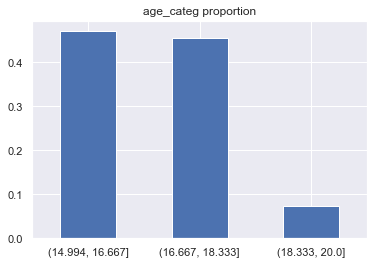

In [14]:
# Вывод состава категориальной колонки
compos = display_cat_compos(stud, column+'_categ')

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Статистические характеристики колонки age


age
count  395.000000
mean    16.688608
std      1.251090
min     15.000000
25%     16.000000
50%     17.000000
75%     18.000000
max     20.000000


Выбросы не обнаружены


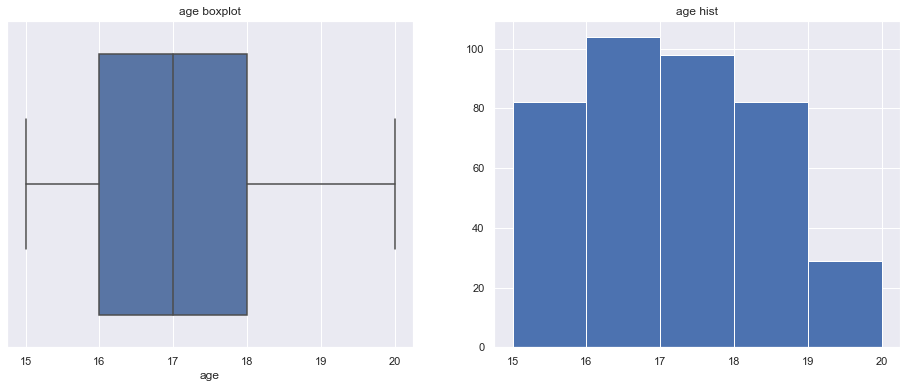

In [15]:
# Вывод состава колонки
compos = display_num_compos(stud, column)

**Вывод по столбцу 'age'**: В данном столбце отсутствуют пропуски. Возраст студентов имеет близкое к нормальному распределение. **Устранён** один **выброс - 22 года**. Введён возраст "20", вбирающий в себя от 20 лет

### adress
Тип адреса ученика: **'U'** - городской, **'R'** - за городом.

Количество None-пропусков: 17
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 4.3%

Состав колонки adress


total  proportion
U    295    0.780423
R     83    0.219577

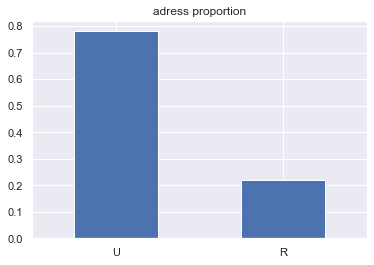

In [16]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'adress'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

### Варианты [заполнения пропусков](https://gallery.azure.ai/Experiment/Methods-for-handling-missing-values-1):
- помещение пропусков в **отдельную группу**, например со значением "0" (*положим, что этот метод актуален при доле пропусков больше **15-20%** *);
- замена пропусков **мерами центра**: модой, медианой, средним и т.д.;
- замена **на соседнее** значение;
- **интерполяция** значений *(актуально для временных рядов)*;
- создание **отдельного столбца с bool-типом** для отслеживания какие 
значения присутствовали в исходном датасете, а какие были искусственно введены.
Применяется при *большом количестве пропусков*;
- учёт уже имеющейся в колонке пропорции между дискретными значениями;
- применение метода **"приписывания"** (*Imputation method*), подразумевающего наличие взаимосвязи значений рассматриваемого столбца с другими, на основе которой можно предположить, какое значение могло быть вместо пропуска. Особенно актуально применение данного метода при наличии корреляции данной колонки
с другой.

Для реализации последних двух методов: **учёта пропорции** в колонке и метода **"приписывания"** была написана функция mod_eda.**fill_rand**(main_series, *sub_series=pd.Series([])*): 
- Если подать на вход в неё только одну колонку, то она заполнит имеющиеся в ней пропуски на основе определённой пропорции между значениями. *Реализовано на генераторе случайных чисел и сопоставлении случайного числа с неравенствами, имеющими тем больший размах, чем больше пропорция для рассматриваемого значения. При попадании случайного числа в определённый интервал, рассматриваемый пропуск заполняется значением, соответствующим этому интервалу*.
- При подаче дополнительной колонки на вход функции, расчёт распределения вероятностей ведётся по теореме [Томаса Байеса](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%B0):
$$p(H_i|A) = \frac{p(H_i)*p(A|H_i)}{p(A)}, $$
где $p(H_i|A)$ - искомая апостериорная вероятность (после опыта) гипотезы $H_i$ при наступлении события $A$;
$p(H_i)$ - априорная вероятность гипотезы (то есть до опыта);
$p(A|H_i)$ - вероятность наступления события $A$ при истинности гипотезы $H_i$;
$p(A)$ - полная вероятность наступления события $A$.

Для начала реализуем метод **"приписывания"** вручную, а затем сопоставим результат с работой написанной функции.
Найдём ту колонку, которая, исходя из логических соображений, может коррелировать с рассматриваемой. Для числовых колонок можно находить корреляцию посредством функции **.corr()**, применяемой к датафрейму.

#### Для решения этой задачи была написана функция нахождения колонок, имеющих статистически значимую взаимосвязь с изучаемой
**Идея:** найти те колонки, в которых расхождение в распределении значений по параметрам исследуемой колонки имеет статистическую значимость.

Данная идея была реализована посредством написанной функции mod_eda.**get_col_depend**(...)

In [17]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
0       school     True      1.0000         6.952          6.952
11  traveltime     True      0.8333         5.242          4.544
21    internet     True      1.0000         3.310          3.310
2          age     True      0.3333         3.290          2.605
29   age_categ     True      0.6667         2.693          2.394

Тестирование гипотез о разности выборочных пропорций показало, что есть статистически значимая взаимосвязь с "school","internet", "traveltime"

In [18]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['school', 'internet', 'traveltime']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки adress


total  proportion
U    295    0.780423
R     83    0.219577




1) Распределение значений колонки school по значениям изучаемой колонки adress


school        GP        MS
adress                    
R       0.178042  0.560976
U       0.821958  0.439024


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки adress по значениям колонки school


school
GP  0.705882
MS  0.294118




2) Распределение значений колонки internet по значениям изучаемой колонки adress


internet        no       yes
adress                      
R         0.425926  0.185567
U         0.574074  0.814433


Количество строк с пропусками в обеих колонках: 1

Состав для None-значений изучаемой колонки adress по значениям колонки internet


internet
yes     0.875
no      0.125




3) Распределение значений колонки traveltime по значениям изучаемой колонки adress


traveltime       1.0       2.0       3.0       4.0
adress                                            
R           0.145299  0.285714  0.571429  0.571429
U           0.854701  0.714286  0.428571  0.428571


Количество строк с пропусками в обеих колонках: 3

Состав для None-значений изучаемой колонки adress по значениям колонки traveltime


traveltime
1.0    0.571429
2.0    0.357143
3.0    0.071429

Заполним пропуски функцией mod_eda.**fill_rand**.

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки adress


total  proportion
U    308    0.779747
R     87    0.220253

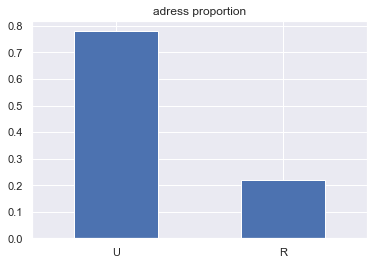

In [19]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'school'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

Заполнение функцией mod_eda.**fill_rand** дало пропорцию между значениями более близкую к изначальной c расхождением в 1%.

**Вывод по столбцу 'adress'**: Таким образом, **17** пропущенных значений колонки **adress** были заполнены методом **приписывания**, то есть с учётом данных в других колонках. Наиболее ярко выраженная статистически значимая связь с **"school"**, **"traveltime"**, **"internet"**, **"age"**, **"m_edu"**.

Около 78% учеников **живёт в городе**.

### famsize
Размер семьи: 'LE3' <= 3, 'GT3' >3

Количество None-пропусков: 27
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 6.8%

Состав колонки famsize


total  proportion
GT3    261    0.709239
LE3    107    0.290761

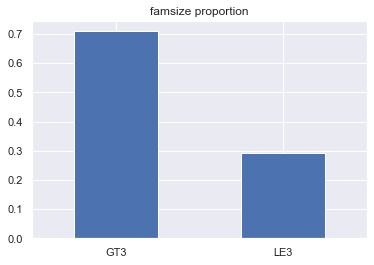

In [20]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'famsize'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

Найдём колонки со статистически значимой взаимосвязью.

In [21]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
12           studytime     True      0.5000         2.295          1.915
19  studytime_granular     True      0.5000         2.295          1.915
15              famsup     True      1.0000         0.907          0.907
28               score     True      0.1111         1.604          0.801
18             nursery     True      1.0000         0.593          0.593

Рассмотрим взаимосвязь с "studytime" и "famsup", имеющих наибольшее отношение alpha/p_value.

In [22]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['studytime', 'famsup']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки famsize


total  proportion
GT3    261    0.709239
LE3    107    0.290761




1) Распределение значений колонки studytime по значениям изучаемой колонки famsize


studytime       1.0       2.0       3.0       4.0
famsize                                          
GT3        0.684211  0.662983  0.883333  0.692308
LE3        0.315789  0.337017  0.116667  0.307692


Количество строк с пропусками в обеих колонках: 1

Состав для None-значений изучаемой колонки famsize по значениям колонки studytime


studytime
2.0   0.500000
1.0   0.307692
3.0   0.153846
4.0   0.038462




2) Распределение значений колонки famsup по значениям изучаемой колонки famsize


famsup         no       yes
famsize                    
GT3      0.645669  0.759615
LE3      0.354331  0.240385


Количество строк с пропусками в обеих колонках: 6

Состав для None-значений изучаемой колонки famsize по значениям колонки famsup


famsup
yes  0.52381
no   0.47619

Ввиду того, что количество строк с пропусками в обеих колонках меньше в первом варианте, а также alpha/p_value максимально, заполним с помощью колонки **'studytime'**

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки famsize


total  proportion
GT3    278    0.703797
LE3    117    0.296203

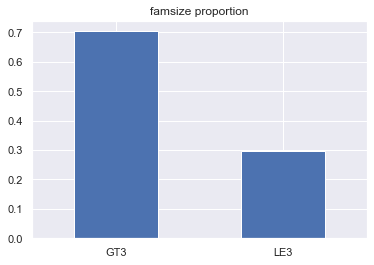

In [23]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'studytime'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'famsize'**: **27** пропущенных значений колонки **famsize** были заполнены методом **приписывания** на основе **"studytime"**. Наиболее сильная статистически значимая связь с **"studytime"**, **"famsup"**.

Около 70% учеников живёт в семье с размером семьи **больше 3х человек**.

### **p_status**
Cтатус совместного жилья родителей: **'T'** - живут вместе, **'A'** - раздельно.

Количество None-пропусков: 45
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 11.4%

Состав колонки p_status


total  proportion
T    314    0.897143
A     36    0.102857

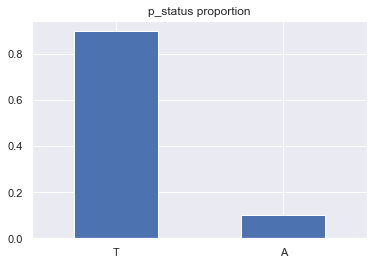

In [24]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'p_status'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

Найдём колонки со статистически значимой связью.

In [25]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
5        m_edu     True         0.4         1.445          1.016
2          age     True         0.2         1.190          0.733
24    freetime     True         0.2         0.745          0.593
17  activities     True         1.0         0.560          0.560
6        f_edu     True         0.3         0.733          0.513

In [26]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['age', 'm_edu', 'freetime']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки p_status


total  proportion
T    314    0.897143
A     36    0.102857




1) Распределение значений колонки age по значениям изучаемой колонки p_status


age             15        16   17        18   19   20
p_status                                             
A         0.136986  0.088889  0.1  0.069444  0.1  0.4
T         0.863014  0.911111  0.9  0.930556  0.9  0.6


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки p_status по значениям колонки age


age
16  0.311111
18  0.222222
15  0.200000
17  0.177778
19  0.088889




2) Распределение значений колонки m_edu по значениям изучаемой колонки p_status


m_edu     0.0       1.0       2.0       3.0       4.0
p_status                                             
A         0.0  0.019231  0.066667  0.168675  0.123967
T         1.0  0.980769  0.933333  0.831325  0.876033


Количество строк с пропусками в обеих колонках: 2

Состав для None-значений изучаемой колонки p_status по значениям колонки m_edu


m_edu
3.0  0.325581
2.0  0.279070
4.0  0.232558
1.0  0.162791




3) Распределение значений колонки freetime по значениям изучаемой колонки p_status


freetime     1.0       2.0       3.0       4.0       5.0
p_status                                                
A         0.1875  0.113208  0.120301  0.047619  0.151515
T         0.8125  0.886792  0.879699  0.952381  0.848485


Количество строк с пропусками в обеих колонках: 1

Состав для None-значений изучаемой колонки p_status по значениям колонки freetime


freetime
3.0  0.454545
2.0  0.227273
4.0  0.159091
5.0  0.113636
1.0  0.045455

Для заполнения пропусков воспользуемся наиболее сильно связанной с изучаемой колонкой - "m_edu".
"age" даёт статистическую связь ввиду наличия выбросов

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки p_status


total  proportion
T    358    0.906329
A     37    0.093671

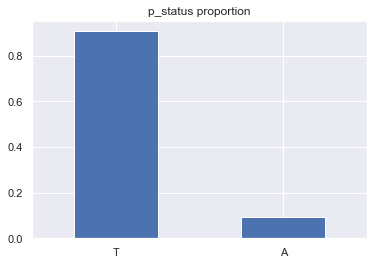

In [27]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'm_edu'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'p_status'**: **45** пропущенных значений колонки **p_status** были заполнены методом **приписывания** на основе колонки **"m_edu"**. Наиболее сильная статистически значимая связь с **"age"**, **"m_edu"**, **"freetime"**.

Около 90% учеников живёт в семье с родителями, живущими **вместе**.

### m_edu
Образование матери: **0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее.

Преобразовано ниже в: **0** - 4 класса и меньше, **1** - 5-9 классы,
    **2** - среднее специальное или 11 классов, **3** - высшее.

In [28]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'm_edu'
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 3
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 0.8%

Состав колонки m_edu


total  proportion
4.0    131    0.334184
2.0    102    0.260204
3.0     97    0.247449
1.0     59    0.150510
0.0      3    0.007653

Количество None-пропусков: 3
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 0.8%

Состав колонки m_edu


total  proportion
3.0    131    0.334184
1.0    102    0.260204
2.0     97    0.247449
0.0     62    0.158163

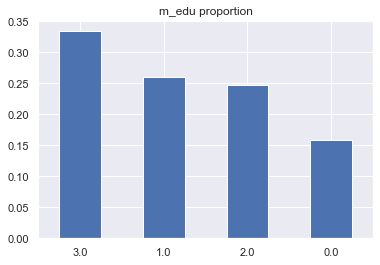

In [29]:
# Заполним в соответствии с вышеобозначенными категориями
def refilling_col(row):
    if pd.isna(row):
        return row
    elif row == 0:
        return 0
    else:
        return row - 1
stud[column] = stud[column].apply(refilling_col) 

# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [30]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
7      m_job     True      0.6500        21.625         20.267
8      f_job     True      0.2500         8.889          7.890
6      f_edu     True      0.2167         7.694          6.581
13  failures     True      0.2500         4.285          3.514
0     school     True      0.7500         3.841          3.364

Так как пропущенных значений всего 3, заполним пропуски вручную.

In [31]:
stud[stud[column].isna()]

school sex  age adress famsize p_status  m_edu  f_edu     m_job     f_job  \
92      GP   F   16      U     LE3        T    NaN    1.0     other     other   
193     GP   M   16      R     GT3        T    NaN    3.0  services  services   
239     GP   M   18      U     GT3        T    NaN    2.0     other  services   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
92         home   father         1.0        2.0       0.0       yes    yes   
193  reputation   mother         1.0        1.0       0.0        no    yes   
239  reputation   father         1.0        2.0       1.0        no     no   

    paid activities nursery  studytime_granular higher internet romantic  \
92    no         no     yes                -6.0    yes       no       no   
193   no        yes     yes                -3.0    yes      yes       no   
239   no         no     yes                -6.0     no      NaN      NaN   

     famrel  freetime  goout  health_level  absences  score         age_categ  
92      3.0       3.0    NaN           2.0       4.0   30.0  (14.994, 16.667]  
193     4.0       3.0    2.0           5.0       8.0   50.0  (14.994, 16.667]  
239     5.0       5.0    4.0           2.0       0.0    0.0  (16.667, 18.333]

In [32]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['m_job', 'f_job']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки m_edu


total  proportion
3.0    131    0.334184
1.0    102    0.260204
2.0     97    0.247449
0.0     62    0.158163




1) Распределение значений колонки m_job по значениям изучаемой колонки m_edu


m_job   at_home   health     other  services   teacher
m_edu                                                 
0.0    0.465517  0.03125  0.206107  0.051546  0.000000
1.0    0.362069  0.06250  0.343511  0.309278  0.000000
2.0    0.137931  0.15625  0.282443  0.391753  0.054545
3.0    0.034483  0.75000  0.167939  0.247423  0.945455


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки m_edu по значениям колонки m_job


m_job
other     0.666667
services  0.333333




2) Распределение значений колонки f_job по значениям изучаемой колонки m_edu


f_job  at_home    health     other  services   teacher
m_edu                                                 
0.0     0.3125  0.066667  0.158163      0.19  0.034483
1.0     0.3750  0.266667  0.295918      0.25  0.034483
2.0     0.0625  0.200000  0.280612      0.26  0.068966
3.0     0.2500  0.466667  0.265306      0.30  0.862069


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки m_edu по значениям колонки f_job


f_job
services  0.666667
other     0.333333

На основе анализа колонки 'm_job' было принято решения заполнить пропуски следующим образом:

In [33]:
def fillna_m_edu(row):
    if pd.isna(row['m_edu']):
        if row['m_job'] == 'other':
            return 2
        else:
            return 3
    return row['m_edu']


stud[column] = stud.apply(fillna_m_edu, axis=1)

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки m_edu


total  proportion
3    132    0.334177
1    102    0.258228
2     99    0.250633
0     62    0.156962

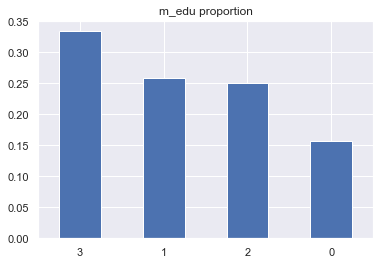

In [34]:
# После заполнения Nan превратим колонку в int
stud[column] = stud[column].astype(int)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'm_edu'**: **3** пропущенных значений колонки были заполнены вручную на основе данных колонки **"f_job"**. Наиболее сильная статистически значимая связь c **"m_job"**, **"f_job"**, **"f_edu"**, **"failures"**, **"school"**.

Наибольшее количество матерей с **высшим** образованием

### f_edu
Образование отца: **0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее

Преобразовано ниже в: **0** - 4 класса и меньше, **1** - 5-9 классы,
    **2** - среднее специальное или 11 классов, **3** - высшее.

In [35]:
# ОЗНАКОМЛЕНИЕМ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'f_edu'
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 24
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 6.1%

Состав колонки f_edu


total  proportion
2.0     106    0.285714
3.0      96    0.258760
4.0      88    0.237197
1.0      78    0.210243
0.0       2    0.005391
40.0      1    0.002695

Имеется значение несоответствующее заявленным категориям. Логично предположить, что это значение "4" с опечаткой, исправим его.

In [36]:
stud['f_edu'] = stud['f_edu'].replace(40, 4)

# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 24
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 6.1%

Состав колонки f_edu


total  proportion
2.0    106    0.285714
3.0     96    0.258760
4.0     89    0.239892
1.0     78    0.210243
0.0      2    0.005391

In [37]:
# Перезаполнение категорий, аналогично "m_edu"
def refilling_col(row):
    if pd.isna(row):
        return row
    elif row == 0:
        return 0
    else:
        return row - 1
stud[column] = stud[column].apply(refilling_col) 

Количество None-пропусков: 24
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 6.1%

Состав колонки f_edu


total  proportion
1.0    106    0.285714
2.0     96    0.258760
3.0     89    0.239892
0.0     80    0.215633

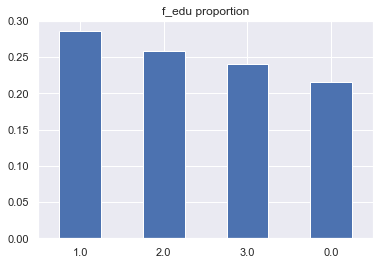

In [38]:
# Вывод состава колонки
compos = display_cat_compos(stud, column)

Найдём взаимосвязанные колонки

In [39]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
6      m_edu     True      0.9167           inf            inf
8      f_job     True      0.3500        16.828         15.682
13  failures     True      0.2083         7.834          7.135
7      m_job     True      0.5750         5.791          4.435
20    higher     True      0.2500         2.533          2.533

Проанализируем взаимосвязь c колонками "m_edu", "failures", "f_job"

In [40]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['m_edu', 'failures', 'f_job']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки f_edu


total  proportion
1.0    106    0.285714
2.0     96    0.258760
3.0     89    0.239892
0.0     80    0.215633




1) Распределение значений колонки m_edu по значениям изучаемой колонки f_edu


m_edu         0         1         2         3
f_edu                                        
0.0    0.644068  0.275510  0.152174  0.008197
1.0    0.254237  0.479592  0.282609  0.147541
2.0    0.084746  0.173469  0.369565  0.327869
3.0    0.016949  0.071429  0.195652  0.516393


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки f_edu по значениям колонки m_edu


m_edu
3  0.416667
2  0.291667
1  0.166667
0  0.125000




2) Распределение значений колонки failures по значениям изучаемой колонки f_edu


failures       0.0       1.0       2.0       3.0
f_edu                                           
0.0       0.169065  0.355556  0.214286  0.800000
1.0       0.284173  0.288889  0.428571  0.133333
2.0       0.276978  0.200000  0.214286  0.066667
3.0       0.269784  0.155556  0.142857  0.000000


Количество строк с пропусками в обеих колонках: 3

Состав для None-значений изучаемой колонки f_edu по значениям колонки failures


failures
0.0  0.714286
1.0  0.190476
2.0  0.095238




3) Распределение значений колонки f_job по значениям изучаемой колонки f_edu


f_job   at_home    health     other  services   teacher
f_edu                                                  
0.0    0.214286  0.076923  0.263158  0.202128  0.000000
1.0    0.428571  0.076923  0.305263  0.287234  0.000000
2.0    0.214286  0.230769  0.268421  0.329787  0.038462
3.0    0.142857  0.615385  0.163158  0.180851  0.961538


Количество строк с пропусками в обеих колонках: 2

Состав для None-значений изучаемой колонки f_edu по значениям колонки f_job


f_job
services  0.363636
other     0.318182
teacher   0.136364
at_home   0.090909
health    0.090909

Воспользуемся колонкой "m_edu" для заполнения пропусков

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки f_edu


total  proportion
1    110    0.278481
3    101    0.255696
2    101    0.255696
0     83    0.210127

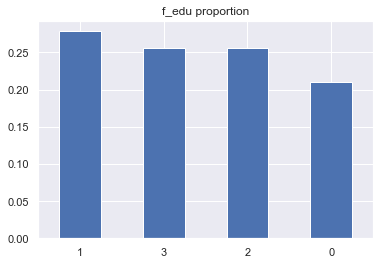

In [41]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'm_edu'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

# После заполнения Nan превратим колонку в int
stud[column] = stud[column].astype(int)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'f_edu'**: **24** пропущенных значений колонки были заполнены методом **приписывания**. Наиболее сильная статистически значимая связь c **"m_edu"**, **"f_job"**, **"failures"**, **"m_job"**.

Наибольшее количество отцов с образованием **5-9 классы**.

### union_edu

Создадим колонку, объединяющую в себе "m_edu" и "f_edu". Проведённый анализ влияния на показатель **"score"** показал наличие отличия степени влияния в 1.5 раза в пользу "m_edu", учтём это.

Уровень среднего семейного образования от **0** - низкий (уровень начальной школы) до **3** - высокий (ВУЗ).

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки union_edu


total  proportion
3    153    0.387342
2    105    0.265823
1     97    0.245570
0     40    0.101266

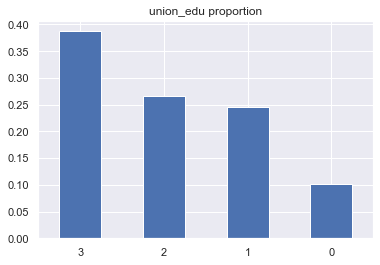

In [42]:
stud['union_edu'] = stud.apply(lambda x: math.ceil((1.5*x['m_edu'] + x['f_edu'])/2.5), axis=1)
# Вывод состава колонки
compos = display_cat_compos(stud, 'union_edu')

### m_job
Работа матери: **'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **services'** - гос служба, **'at_home'** - не работает, **'other'** - другое.

Количество None-пропусков: 19
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 4.8%

Состав колонки m_job


total  proportion
other       133    0.353723
services     98    0.260638
at_home      58    0.154255
teacher      55    0.146277
health       32    0.085106

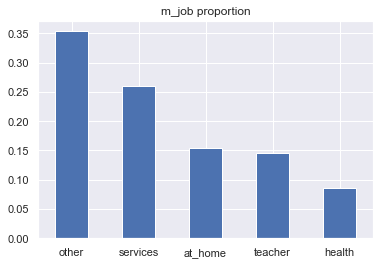

In [43]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'm_job'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [44]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
6       m_edu     True      0.5000        12.831         11.655
30  union_edu     True      0.4333         7.282          6.179
7       f_edu     True      0.5333         4.989          3.815
8       f_job     True      0.2200         4.112          3.288
21   internet     True      0.2000         2.858          2.858

Проанализируем связь с образованием матери.

In [45]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['m_edu']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки m_job


total  proportion
other       133    0.353723
services     98    0.260638
at_home      58    0.154255
teacher      55    0.146277
health       32    0.085106




1) Распределение значений колонки m_edu по значениям изучаемой колонки m_job


m_edu            0         1         2      3
m_job                                        
at_home   0.450000  0.214286  0.086022  0.016
health    0.016667  0.020408  0.053763  0.192
other     0.450000  0.459184  0.419355  0.176
services  0.083333  0.306122  0.408602  0.200
teacher   0.000000  0.000000  0.032258  0.416


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки m_job по значениям колонки m_edu


m_edu
3  0.368421
2  0.315789
1  0.210526
0  0.105263

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки m_job


total  proportion
other       140    0.354430
services    104    0.263291
at_home      60    0.151899
teacher      57    0.144304
health       34    0.086076

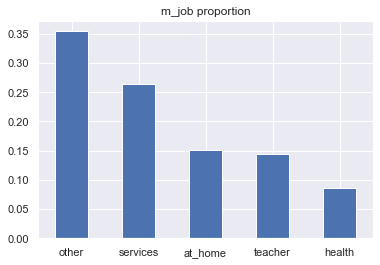

In [46]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'm_edu'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'm_job'**: **19** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_edu"**. Наиболее сильная статистически значимая связь c **"m_edu"**, **"f_edu"**, **"f_job"**, **"internet"**, **"sex"**.

Наибольшее количество матерей работает (помимо варианта **"другое"**) **на гос. службе**.

### f_job
Работа отца: **'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **services'** - гос служба, **'at_home'** - не работает, **'other'** - другое.

Количество None-пропусков: 36
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 9.1%

Состав колонки f_job


total  proportion
other       197    0.548747
services    102    0.284123
teacher      29    0.080780
at_home      16    0.044568
health       15    0.041783

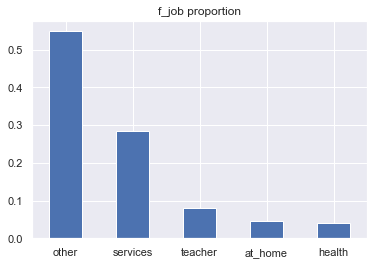

In [47]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'f_job'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

Выборка значений "at_home" и "health" мала (меньше 30), в связи с чем эти значения не проанализировать с использованием теста Стьюдента. Принято решение эти значения отнести к разделу "other" (тем более, что построение boxplot показало, что распределение по **score** этих значений мало отличается от "other")

In [48]:
stud[column] = stud[column].apply(lambda x: x if not(x in ['at_home', 'health']) else 'other')

In [49]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
8      m_job     True      0.5333         5.496          4.366
7      f_edu     True      0.2222         1.781          1.426
6      m_edu     True      0.1667         1.714          1.293
0     school     True      0.6667         1.466          1.238
10  guardian     True      0.5556         1.585          1.156

Проанализируем связь с работой матери и образованием отца

In [50]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['m_job', 'f_edu']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки f_job


total  proportion
other       197    0.548747
services    102    0.284123
teacher      29    0.080780
at_home      16    0.044568
health       15    0.041783




1) Распределение значений колонки m_job по значениям изучаемой колонки f_job


m_job      at_home    health     other  services   teacher
f_job                                                     
other     0.703704  0.750000  0.781250  0.457447  0.472727
services  0.259259  0.214286  0.171875  0.457447  0.309091
teacher   0.037037  0.035714  0.046875  0.085106  0.218182


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки f_job по значениям колонки m_job


m_job
other     0.333333
services  0.277778
at_home   0.166667
health    0.166667
teacher   0.055556




2) Распределение значений колонки f_edu по значениям изучаемой колонки f_job


f_edu            0         1         2         3
f_job                                           
other     0.710526  0.708333  0.634409  0.500000
services  0.276316  0.291667  0.354839  0.212766
teacher   0.013158  0.000000  0.010753  0.287234


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки f_job по значениям колонки f_edu


f_edu
1  0.388889
2  0.222222
3  0.194444
0  0.194444

Остановимся на связи с работой матери, как наиболее сильно связанной колонке с работой отца

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки f_job


total  proportion
other       252    0.637975
services    112    0.283544
teacher      31    0.078481

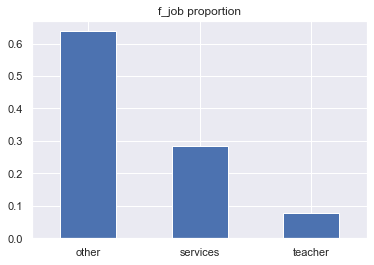

In [51]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'm_job'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'f_job'**: **36** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_job"**. Наиболее сильная статистически значимая связь с **"m_job"**, **"m_edu"**, **"school"**, **"guardian"**.

Были оставлены значения "other", "services", "teacher"

Наибольшее количество отцов также работает (помимо варианта **"другое"**) **на гос. службе**.

### reason
Причина выбора школы: **'home'** - близость к дому, **'reputation'** - репутация школы, 
    **'course'** - образовательная программа, **'other'** - другое.

Количество None-пропусков: 17
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 4.3%

Состав колонки reason


total  proportion
course        137    0.362434
home          104    0.275132
reputation    103    0.272487
other          34    0.089947

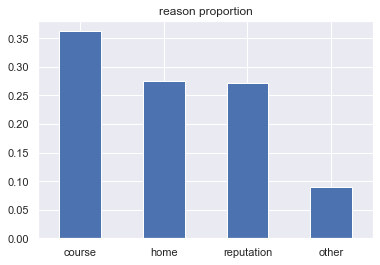

In [52]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'reason'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [53]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
19  studytime_granular     True        0.50         4.623          3.545
12           studytime     True        0.50         4.623          3.545
0               school     True        0.25         1.852          1.852
17          activities     True        0.25         1.487          1.487
3               adress     True        0.25         1.401          1.401

Проанализируем связь с временем на учёбу и адресом проживания

In [54]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['school', 'activities', 'studytime', 'adress']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки reason


total  proportion
course        137    0.362434
home          104    0.275132
reputation    103    0.272487
other          34    0.089947




1) Распределение значений колонки school по значениям изучаемой колонки reason


school            GP        MS
reason                        
course      0.354167  0.428571
home        0.279762  0.238095
other       0.074405  0.214286
reputation  0.291667  0.119048


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки reason по значениям колонки school


school
GP  0.764706
MS  0.235294




2) Распределение значений колонки activities по значениям изучаемой колонки reason


activities        no       yes
reason                        
course      0.381215  0.336957
home        0.309392  0.250000
other       0.099448  0.076087
reputation  0.209945  0.336957


Количество строк с пропусками в обеих колонках: 1

Состав для None-значений изучаемой колонки reason по значениям колонки activities


activities
yes      0.6875
no       0.3125




3) Распределение значений колонки studytime по значениям изучаемой колонки reason


studytime        1.0       2.0       3.0   4.0
reason                                        
course      0.453608  0.322751  0.393443  0.28
home        0.268041  0.312169  0.229508  0.16
other       0.144330  0.068783  0.098361  0.00
reputation  0.134021  0.296296  0.278689  0.56


Количество строк с пропусками в обеих колонках: 1

Состав для None-значений изучаемой колонки reason по значениям колонки studytime


studytime
1.0     0.3750
2.0     0.3125
3.0     0.1875
4.0     0.1250




4) Распределение значений колонки adress по значениям изучаемой колонки reason


adress             R         U
reason                        
course      0.395349  0.352740
home        0.162791  0.308219
other       0.116279  0.082192
reputation  0.325581  0.256849


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки reason по значениям колонки adress


adress
U  0.941176
R  0.058824

Заполним пропуски в соответствии со значениями колонки "studytime" (больше вариаций значений для None-колонки)

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки reason


total  proportion
course        142    0.359494
home          113    0.286076
reputation    105    0.265823
other          35    0.088608

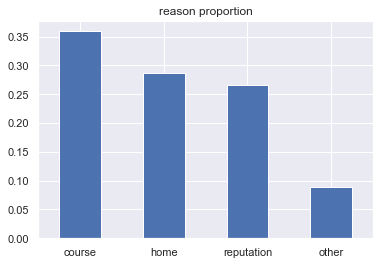

In [55]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'studytime'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'reason'**: **17** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"studytime"**. Наиболее сильная статистически значимая связь с **"studytime"**, **"school"**, **"adress"**, **"activities"**.

Наибольшее количество причин выбора школы связаны с **образовательной программой**.

### guardian
Опекун: **'mother'** - мать, **'father'** - отец, **'other'** - другое.
По всей видимости здесь имеется в виду, кто из родителей (или не из родителей в случае "other") является наиболее сильно заботящимся о ребёнке

Количество None-пропусков: 31
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 7.8%

Состав колонки guardian


total  proportion
mother    250    0.686813
father     86    0.236264
other      28    0.076923

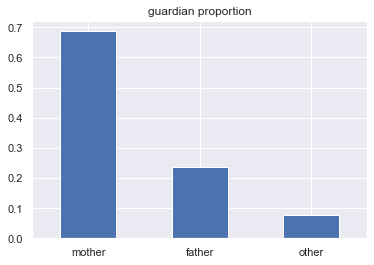

In [56]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'guardian'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

Проведённый ниже анализ взаимосвязи данной колонкой со "score" показал, что сильнее всего влияет является ли опекун родной матерью/отцом или кем-то ещё, в связи с чем объединим колонку мать-отец.

In [57]:
stud[column] = stud[column].apply(lambda x: 'parent' if (x in ['mother', 'father']) else x)

In [58]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
2         age     True      0.3000           inf            inf
29  age_categ     True      0.3333           inf            inf
13   failures     True      0.2500         6.105          5.649
18    nursery     True      1.0000         2.350          2.350
30  union_edu     True      0.6667         2.082          1.572

Рассмотрим взаимосвязь с колонками

In [59]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['age_categ', 'nursery', 'failures']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки guardian


total  proportion
mother    250    0.686813
father     86    0.236264
other      28    0.076923




1) Распределение значений колонки age_categ по значениям изучаемой колонки guardian


age_categ  (14.994, 16.667]  (16.667, 18.333]  (18.333, 20.0]
guardian                                                     
other              0.022989          0.030488        0.730769
parent             0.977011          0.969512        0.269231


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки guardian по значениям колонки age_categ


age_categ
(16.667, 18.333]   0.516129
(14.994, 16.667]   0.387097
(18.333, 20.0]     0.096774




2) Распределение значений колонки nursery по значениям изучаемой колонки guardian


nursery        no       yes
guardian                   
other     0.15942  0.046429
parent    0.84058  0.953571


Количество строк с пропусками в обеих колонках: 1

Состав для None-значений изучаемой колонки guardian по значениям колонки nursery


nursery
yes  0.666667
no   0.333333




3) Распределение значений колонки failures по значениям изучаемой колонки guardian


failures       0.0       1.0       2.0       3.0
guardian                                        
other     0.036765  0.217391  0.357143  0.181818
parent    0.963235  0.782609  0.642857  0.818182


Количество строк с пропусками в обеих колонках: 1

Состав для None-значений изучаемой колонки guardian по значениям колонки failures


failures
0.0  0.700000
3.0  0.133333
1.0  0.100000
2.0  0.066667

Для заполнения пропусков была выбрана колонка **age_categ**.

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки guardian


total  proportion
parent    363    0.918987
other      32    0.081013

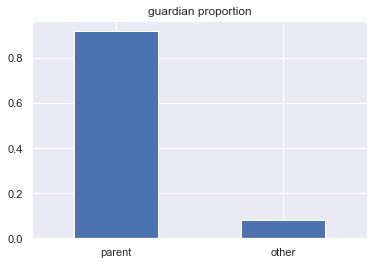

In [60]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'age_categ'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'guardian'**: **31** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"f_job"**. Наиболее сильная статистически значимая связь с **"age/age_categ"**, **"failures"**, **"nursery"**.

Вместо "mother"-"father": "parent".
Размер выборки "other" в районе **30**.

Наибольшее количество опекунов - **матери**.

### traveltime
Время в пути до школы: **1** - <15 мин., **2** - 15-30 мин., 
    **3** - 30-60 мин., **4** - >60 мин.

Преобразовано ниже в: **0** - <15 мин., **1** - 15-30 мин., 
    **2** - больше 30 мин.

In [61]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'traveltime'
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 28
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 7.1%

Состав колонки traveltime


total  proportion
1.0    242    0.659401
2.0     96    0.261580
3.0     22    0.059946
4.0      7    0.019074

In [62]:
# Перезаполнение категорий
def refilling_col_up(row):
    if pd.isna(row):
        return row
    elif (row == 4) or (row == 3):
        return 2
    else:
        return row - 1
stud[column] = stud[column].apply(refilling_col_up) 

In [63]:
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 28
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 7.1%

Состав колонки traveltime


total  proportion
0.0    242    0.659401
1.0     96    0.261580
2.0     29    0.079019

In [64]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
3      adress     True      1.0000         5.689          5.336
0      school     True      1.0000         5.734          5.257
29  age_categ     True      0.2222         1.687          1.595
6       m_edu     True      0.4444         2.363          1.508
30  union_edu     True      0.3889         2.041          1.355

Наиболее сильная взаимосвязь колонки **'traveltime'** с **'school'** и **'adress'**

In [65]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['school', 'adress']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки traveltime


total  proportion
0.0    242    0.659401
1.0     96    0.261580
2.0     29    0.079019




1) Распределение значений колонки school по значениям изучаемой колонки traveltime


school            GP        MS
traveltime                    
0.0         0.704615  0.309524
1.0         0.233846  0.476190
2.0         0.061538  0.214286


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки traveltime по значениям колонки school


school
GP  0.857143
MS  0.142857




2) Распределение значений колонки adress по значениям изучаемой колонки traveltime


adress            R         U
traveltime                   
0.0         0.43038  0.722222
1.0         0.35443  0.236111
2.0         0.21519  0.041667


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки traveltime по значениям колонки adress


adress
U  0.714286
R  0.285714

Заполним пропуски на основе колонки 'adress'

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки traveltime


total  proportion
0    262    0.663291
1     98    0.248101
2     35    0.088608

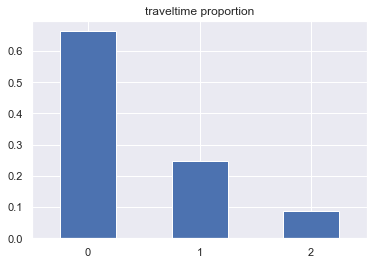

In [66]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'adress'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

# Изменим тип на int
stud[column] = stud[column].astype(int)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'traveltime'**: **28** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"adress"**. Наиболее сильная статистически значимая связь с **"school"**, **"adress"**, **"age_categ"**, **"m_edu"**.

В 65% случаев ученики тратят на дорогу **меньше 15 минут**.

### studytime
Время на учёбу помимо школы в неделю: **1** - <2 часов, **2** - 2-5 часов, 
    **3** - 5-10 часов, **4** - >10 часов.

Преобразовано ниже в **0** - <2 часов, **1** - 2-5 часов, 
    **2** - 5-10 часов и больше.

In [67]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'studytime'
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 7
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 1.8%

Состав колонки studytime


total  proportion
2.0    194    0.500000
1.0    103    0.265464
3.0     64    0.164948
4.0     27    0.069588

In [68]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row
    if row == 4:
        return 2
    else:
        return row - 1
stud[column] = stud[column].apply(refilling_col) 

In [69]:
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 7
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 1.8%

Состав колонки studytime


total  proportion
1.0    194    0.500000
0.0    103    0.265464
2.0     91    0.234536

In [70]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
1          sex     True      1.0000         9.345          8.868
16        paid     True      1.0000         3.722          3.246
20      higher     True      0.3333         2.302          2.302
12  traveltime     True      0.5556         2.506          1.826
10      reason     True      0.5556         2.518          1.794

In [71]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['sex', 'paid', 'higher', 'famsize']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки studytime


total  proportion
1.0    194    0.500000
0.0    103    0.265464
2.0     91    0.234536




1) Распределение значений колонки sex по значениям изучаемой колонки studytime


sex               F         M
studytime                    
0.0        0.127451  0.418478
1.0        0.544118  0.451087
2.0        0.328431  0.130435


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки studytime по значениям колонки sex


sex
F  0.571429
M  0.428571




2) Распределение значений колонки paid по значениям изучаемой колонки studytime


paid             no       yes
studytime                    
0.0        0.340102  0.145695
1.0        0.456853  0.543046
2.0        0.203046  0.311258


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки studytime по значениям колонки paid


paid
yes  0.571429
no   0.428571




3) Распределение значений колонки higher по значениям изучаемой колонки studytime


higher           no       yes
studytime                    
0.0        0.578947  0.240000
1.0        0.421053  0.511429
2.0        0.000000  0.248571


Количество строк с пропусками в обеих колонках: 1

Состав для None-значений изучаемой колонки studytime по значениям колонки higher


higher
yes     1.0




4) Распределение значений колонки famsize по значениям изучаемой колонки studytime


famsize         GT3       LE3
studytime                    
0.0        0.257353  0.284483
1.0        0.466912  0.577586
2.0        0.275735  0.137931


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки studytime по значениям колонки famsize


famsize
GT3  0.857143
LE3  0.142857

Заполним пропуски на основе колонки 'sex'. Анализ показал, что девочки как правило больше уделяют время учёбе, чем мальчики. 

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки studytime


total  proportion
1    195    0.493671
0    106    0.268354
2     94    0.237975

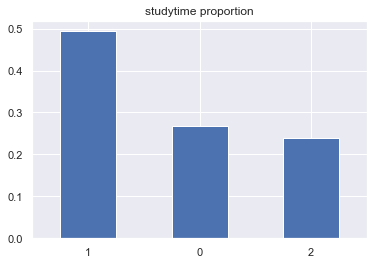

In [72]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'sex'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

# Изменим тип на int
stud[column] = stud[column].astype(int)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'studytime'**: **7** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"sex"**. Наиболее сильная статистически значимая связь с **"sex"**, **"paid"**, **"higher"**, **"reason"**.

Чаще всего ученики выделяют внешкольного времени на учёбу **от 2 до 5 часов** в неделю. 

### failures
Количество внеучебных неудач: **n**, если 1<=n<=3, иначе **0** (вынужденное исправление, так как значения **4** в датасете нет, а есть неописанный **0**. Позднее, было уточнено, что имела место ошибка в описании, и значения **4** действительно нет).

Преобразуем ниже в число неудач от **0** до **2**

Ввиду отсутствия дополнительных разъяснений по поводу данной колонки, в частности, что такое 'внеучебная неудача', **предположим**:
- Значение в этой колонке соответствует **числу проваленных госэкзаменов** *("внеучебных" в значении "не по математике")*
- **0** - отсутствие неудач, то есть остальные предметы были написаны удачно _(однако стоит иметь в виду, что здесь могут иметь место и **скрытые пропуски**)_

In [73]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'failures'
# Вывод состава колонки
compos = display_cat_compos(stud, column,plot=False)

Количество None-пропусков: 22
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 5.6%

Состав колонки failures


total  proportion
0.0    293    0.785523
1.0     49    0.131367
2.0     16    0.042895
3.0     15    0.040214

In [74]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row   
    elif (row == 3) or (row == 2):
        return 2
    else:
        return row
stud[column] = stud[column].apply(refilling_col) 

Количество None-пропусков: 22
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 5.6%

Состав колонки failures


total  proportion
0.0    293    0.785523
1.0     49    0.131367
2.0     31    0.083110

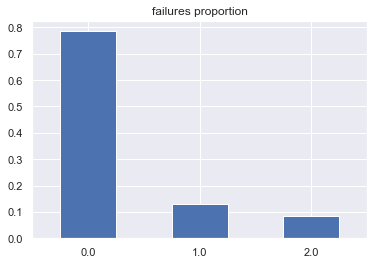

In [75]:
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [76]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
29  age_categ     True      0.7778        11.290         10.448
11   guardian     True      1.0000         8.279          7.801
2         age     True      0.4444         7.878          6.951
30  union_edu     True      0.8333         7.652          6.476
6       m_edu     True      0.7778         6.346          5.200

In [77]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['age_categ', 'guardian', 'm_edu']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки failures


total  proportion
0.0    293    0.785523
1.0     49    0.131367
2.0     31    0.083110




1) Распределение значений колонки age_categ по значениям изучаемой колонки failures


age_categ  (14.994, 16.667]  (16.667, 18.333]  (18.333, 20.0]
failures                                                     
0.0                0.848837          0.810345        0.222222
1.0                0.075581          0.137931        0.444444
2.0                0.075581          0.051724        0.333333


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки failures по значениям колонки age_categ


age_categ
(14.994, 16.667]   0.636364
(16.667, 18.333]   0.272727
(18.333, 20.0]     0.090909




2) Распределение значений колонки guardian по значениям изучаемой колонки failures


guardian     other    parent
failures                    
0.0       0.354839  0.824561
1.0       0.354839  0.111111
2.0       0.290323  0.064327


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки failures по значениям колонки guardian


guardian
parent  0.954545
other   0.045455




3) Распределение значений колонки m_edu по значениям изучаемой колонки failures


m_edu            0         1         2         3
failures                                        
0.0       0.590164  0.781250  0.741935  0.918699
1.0       0.245902  0.135417  0.150538  0.056911
2.0       0.163934  0.083333  0.107527  0.024390


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки failures по значениям колонки m_edu


m_edu
3  0.409091
2  0.272727
1  0.272727
0  0.045455

Было принято решение заполнить пропуски на основе колонки 'age_categ'

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки failures


total  proportion
0    310    0.784810
1     52    0.131646
2     33    0.083544

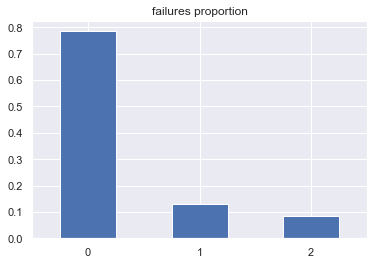

In [78]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'age_categ'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

# Изменим тип на int
stud[column] = stud[column].astype(int)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'failures'**: **22** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"age_categ"**. Наиболее сильная статистически значимая связь с **"age_categ/age"**, **"guardian"**, **"m_edu"**, **"higher"**.

Около **78%** учеников не имеют проблем.

### schoolsup
Дополнительная образовательная поддержка: **yes** или **no**

Количество None-пропусков: 9
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 2.3%

Состав колонки schoolsup


total  proportion
no     335    0.867876
yes     51    0.132124

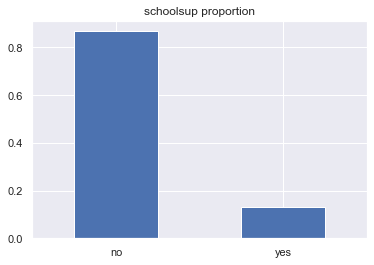

In [79]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'schoolsup'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

Ввиду отсутствия сведений о характере дополнительной образовательной поддержки сложно однозначно ответить на вопрос, имеют ли место **скрытые пропуски**. **Предположим**, за отсутствием альтернативы, что выявленная пропорция соответствует действительности.

In [80]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
29  age_categ     True      0.6667         5.040          4.739
2         age     True      0.2333         3.917          3.259
28      score     True      0.1797         3.000          1.526
0      school     True      0.5000         1.525          1.525
1         sex     True      1.0000         1.492          1.492

Оценим взаимосвязь с колонками "age", "school" 

In [81]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['age_categ', 'school', 'sex']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки schoolsup


total  proportion
no     335    0.867876
yes     51    0.132124




1) Распределение значений колонки age_categ по значениям изучаемой колонки schoolsup


age_categ  (14.994, 16.667]  (16.667, 18.333]  (18.333, 20.0]
schoolsup                                                    
no                 0.774725          0.949153        0.962963
yes                0.225275          0.050847        0.037037


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки schoolsup по значениям колонки age_categ


age_categ
(14.994, 16.667]   0.444444
(16.667, 18.333]   0.333333
(18.333, 20.0]     0.222222




2) Распределение значений колонки school по значениям изучаемой колонки schoolsup


school           GP   MS
schoolsup               
no         0.850877  1.0
yes        0.149123  0.0


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки schoolsup по значениям колонки school


school
GP  0.777778
MS  0.222222




3) Распределение значений колонки sex по значениям изучаемой колонки schoolsup


sex               F         M
schoolsup                    
no         0.823529  0.917582
yes        0.176471  0.082418


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки schoolsup по значениям колонки sex


sex
M  0.555556
F  0.444444

Колонка 'school' интересна тем, что учащимся школы 'MS' 100% не оказывается поддержка (либо **возможно имеют место скрытые пропуски**)

Остановимся на колонке 'sex', девочкам больше помогают.

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки schoolsup


total  proportion
no     340    0.860759
yes     55    0.139241

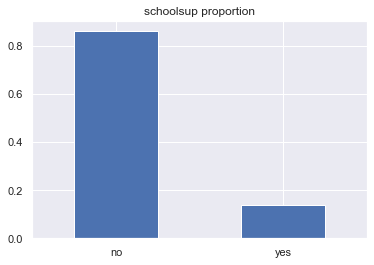

In [82]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'sex'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'schoolsup'**: **9** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"school"**, выбранной на основе наблюдения об отсутствии поддержки в школе "MS". Наиболее сильная статистически значимая связь c **"age_categ/age"**, **"school"**, **"sex"**. Возможно, имеют место **скрытые пропуски** среди значений "no".

В большинстве случаев образовательная **поддержка не оказывается**.

### famsup 
Семейная образовательная поддержка: **yes** или **no**

Количество None-пропусков: 39
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 9.9%

Состав колонки famsup


total  proportion
yes    219    0.615169
no     137    0.384831

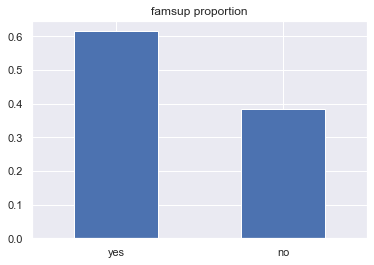

In [83]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'famsup'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [84]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
16     paid     True      1.0000         6.954          6.954
7     f_edu     True      0.8333         3.847          3.151
6     m_edu     True      0.8333         3.334          2.640
0    school     True      1.0000         2.636          2.636
1       sex     True      1.0000         1.955          1.955

In [85]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['paid', 'm_edu', 'school', 'sex']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки famsup


total  proportion
yes    219    0.615169
no     137    0.384831




1) Распределение значений колонки paid по значениям изучаемой колонки famsup


paid          no       yes
famsup                    
no      0.531073  0.223776
yes     0.468927  0.776224


Количество строк с пропусками в обеих колонках: 4

Состав для None-значений изучаемой колонки famsup по значениям колонки paid


paid
no   0.657143
yes  0.342857




2) Распределение значений колонки m_edu по значениям изучаемой колонки famsup


m_edu          0         1         2         3
famsup                                        
no      0.578947  0.417582  0.373626  0.273504
yes     0.421053  0.582418  0.626374  0.726496


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки famsup по значениям колонки m_edu


m_edu
3  0.384615
1  0.282051
2  0.205128
0  0.128205




3) Распределение значений колонки school по значениям изучаемой колонки famsup


school        GP        MS
famsup                    
no      0.350482  0.622222
yes     0.649518  0.377778


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки famsup по значениям колонки school


school
GP  0.974359
MS  0.025641




4) Распределение значений колонки sex по значениям изучаемой колонки famsup


sex            F         M
famsup                    
no      0.307692  0.465517
yes     0.692308  0.534483


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки famsup по значениям колонки sex


sex
F  0.666667
M  0.333333

Остановимся на связи с колонкой 'paid'

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки famsup


total  proportion
yes    239    0.605063
no     156    0.394937

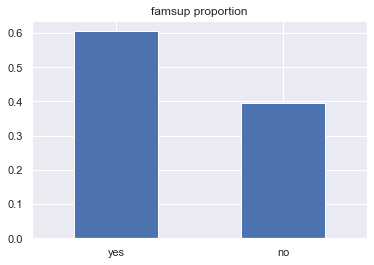

In [86]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'paid'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'famsup'**: **39** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"paid"**. Наиболее сильная статистически значимая связь с **"paid"**, **"m_edu"**, **"school"**, **"sex"**.

Родителями поддержка **оказывается** чаще, чем не оказывается.

### paid 
Дополнительные платные занятия по математике: **yes** или **no**.

Количество None-пропусков: 40
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 10.1%

Состав колонки paid


total  proportion
no     200     0.56338
yes    155     0.43662

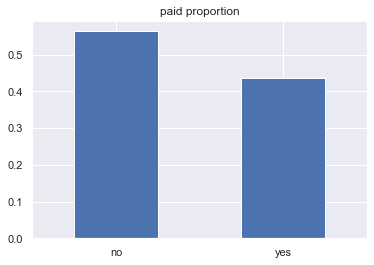

In [87]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'paid'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [88]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
16              famsup     True      1.0000         9.683          9.683
13           studytime     True      0.6667         3.322          3.073
20              higher     True      0.5000         2.823          2.823
19  studytime_granular     True      0.5000         2.783          2.576
6                m_edu     True      0.6667         2.664          2.092

In [89]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['famsup', 'higher', 'studytime']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки paid


total  proportion
no     200     0.56338
yes    155     0.43662




1) Распределение значений колонки famsup по значениям изучаемой колонки paid


famsup        no       yes
paid                      
no      0.772414  0.419048
yes     0.227586  0.580952


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки paid по значениям колонки famsup


famsup
yes   0.725
no    0.275




2) Распределение значений колонки higher по значениям изучаемой колонки paid


higher   no       yes
paid                 
no      1.0  0.540625
yes     0.0  0.459375


Количество строк с пропусками в обеих колонках: 1

Состав для None-значений изучаемой колонки paid по значениям колонки higher


higher
yes  0.923077
no   0.076923




3) Распределение значений колонки studytime по значениям изучаемой колонки paid


studytime        0         1         2
paid                                  
no         0.73913  0.526012  0.455556
yes        0.26087  0.473988  0.544444


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки paid по значениям колонки studytime


studytime
1       0.55
0       0.35
2       0.10

Наибольшая связь, что и логично, имеется с колонкой "famsup"

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки paid


total  proportion
no     223    0.564557
yes    172    0.435443

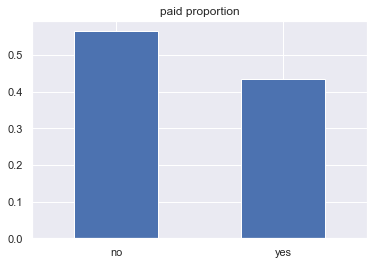

In [90]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'famsup'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'paid'**: **40** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"famsup"**. Наиболее сильная статистически значимая связь с **"famsup"**, **"higher"**, **"studytime"**, **"m_edu"**.

Чаще всего ученики **не прибегают** к дополнительным платным занятиям.

### activities
Дополнительные внеучебные занятия: **yes** или **no**

Количество None-пропусков: 14
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 3.5%

Состав колонки activities


total  proportion
yes    195    0.511811
no     186    0.488189

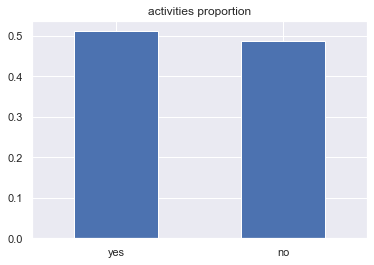

In [91]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'activities'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [92]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
6     m_edu     True      0.3333         1.128          1.039
0    school     True      1.0000         0.894          0.894
10   reason     True      0.5000         0.959          0.876
1       sex     True      1.0000         0.783          0.783
8     m_job     True      0.2000         0.824          0.745

In [93]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['m_edu', 'school', 'sex', 'reason']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки activities


total  proportion
yes    195    0.511811
no     186    0.488189




1) Распределение значений колонки m_edu по значениям изучаемой колонки activities


m_edu             0         1       2         3
activities                                     
no          0.57377  0.479167  0.5625  0.398438
yes         0.42623  0.520833  0.4375  0.601562


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки activities по значениям колонки m_edu


m_edu
1  0.428571
3  0.285714
2  0.214286
0  0.071429




2) Распределение значений колонки school по значениям изучаемой колонки activities


school            GP        MS
activities                    
no          0.467262  0.644444
yes         0.532738  0.355556


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки activities по значениям колонки school


school
GP  0.928571
MS  0.071429




3) Распределение значений колонки sex по значениям изучаемой колонки activities


sex                F         M
activities                    
no          0.539604  0.430168
yes         0.460396  0.569832


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки activities по значениям колонки sex


sex
M  0.571429
F  0.428571




4) Распределение значений колонки reason по значениям изучаемой колонки activities


reason        course      home     other  reputation
activities                                          
no          0.522059  0.527273  0.575758    0.372549
yes         0.477941  0.472727  0.424242    0.627451


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки activities по значениям колонки reason


reason
course      0.428571
home        0.214286
reputation  0.214286
other       0.142857

Остановимся на колонке 'reason', имеющей больше вариантов значений.

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки activities


total  proportion
yes    200    0.506329
no     195    0.493671

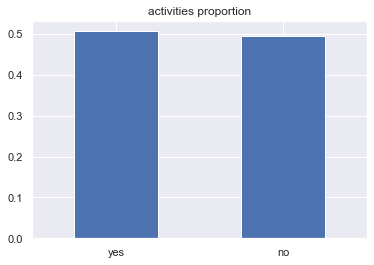

In [94]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'reason'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'activities'**: **14** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"reason"**. Наиболее сильная статистически значимая связь с  **"m_edu"**, **"reason"**, **"school"**, **"sex"**.

Примерно равное количество студентов, имеющих внеучебные занятия и не имеющих.

### studytime_granular

Неизвестная колонка, необходимо понять, с чем она коррелирует

Количество None-пропусков: 7
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 1.8%

Состав колонки studytime_granular


total  proportion
-6.0     194    0.500000
-3.0     103    0.265464
-9.0      64    0.164948
-12.0     27    0.069588

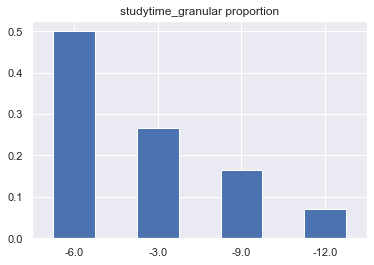

In [95]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'studytime_granular'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [96]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['studytime']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки studytime_granular


total  proportion
-6.0     194    0.500000
-3.0     103    0.265464
-9.0      64    0.164948
-12.0     27    0.069588




1) Распределение значений колонки studytime по значениям изучаемой колонки studytime_granular


studytime             0    1         2
studytime_granular                    
-12.0               0.0  0.0  0.296703
-9.0                0.0  0.0  0.703297
-6.0                0.0  1.0  0.000000
-3.0                1.0  0.0  0.000000


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки studytime_granular по значениям колонки studytime


studytime
2   0.428571
0   0.428571
1   0.142857

Как видно из распределения значений этой колонки по значениям колонки "studytime": колонка "studytime_granular" **дублирует** эту колонку с коэффициентом (-3). С точки зрения оценки влияния на "score" **её использование не имеет смысла**, удалим её.

In [97]:
stud.drop(['studytime_granular'], axis=1, inplace=True)

### nursery
Посещал детский сад: **yes** или **no**

Количество None-пропусков: 16
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 4.1%

Состав колонки nursery


total  proportion
yes    300    0.791557
no      79    0.208443

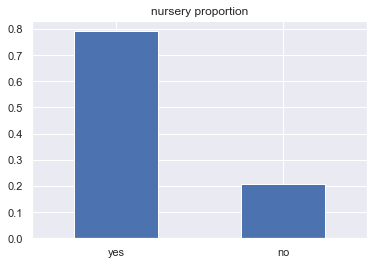

In [98]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'nursery'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [99]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
6       m_edu     True      0.8333         4.311          3.614
29  union_edu     True      0.8333         4.199          3.501
11   guardian     True      1.0000         3.402          3.402
7       f_edu     True      0.6667         2.140          1.588
28  age_categ     True      0.6667         1.284          1.090

In [100]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['guardian', 'm_edu', 'paid']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки nursery


total  proportion
yes    300    0.791557
no      79    0.208443




1) Распределение значений колонки guardian по значениям изучаемой колонки nursery


guardian  other    parent
nursery                  
no          0.5  0.185185
yes         0.5  0.814815


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки nursery по значениям колонки guardian


guardian
parent      0.75
other       0.25




2) Распределение значений колонки m_edu по значениям изучаемой колонки nursery


m_edu           0         1         2        3
nursery                                       
no       0.403509  0.181818  0.239583  0.11811
yes      0.596491  0.818182  0.760417  0.88189


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки nursery по значениям колонки m_edu


m_edu
3  0.3125
0  0.3125
2  0.1875
1  0.1875




3) Распределение значений колонки paid по значениям изучаемой колонки nursery


paid           no       yes
nursery                    
no       0.251163  0.152439
yes      0.748837  0.847561


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки nursery по значениям колонки paid


paid
no    0.5
yes   0.5

Наиболее интересно выглядит распределение в 'm_edu', заполним по нему

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки nursery


total  proportion
yes    312    0.789873
no      83    0.210127

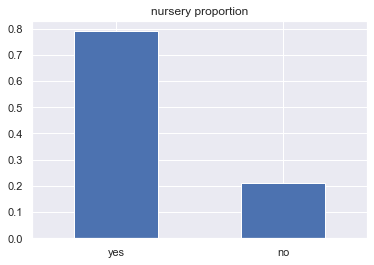

In [101]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'm_edu'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'nursery'**: **16** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_edu"**. Наиболее сильная статистически значимая связь с **"guardian"**, **"m_edu"**, **"paid"**.

Большинство учеников **посещало** детский сад.

### higher
Хочет получить высшее образование: **yes** или **no**

Количество None-пропусков: 20
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 5.1%

Состав колонки higher


total  proportion
yes    356    0.949333
no      19    0.050667

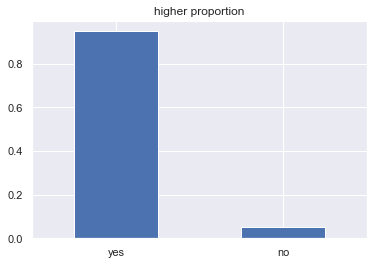

In [102]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'higher'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [103]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
14   failures     True      1.0000         6.163          5.686
17       paid     True      0.5000         3.397          3.397
2         age     True      0.3667         4.296          3.259
29  union_edu     True      0.2500         2.453          2.259
16     famsup     True      0.5000         2.061          2.061

In [104]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['failures', 'paid', 'm_edu']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки higher


total  proportion
yes    356    0.949333
no      19    0.050667




1) Распределение значений колонки failures по значениям изучаемой колонки higher


failures        0    1         2
higher                          
no        0.02381  0.1  0.225806
yes       0.97619  0.9  0.774194


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки higher по значениям колонки failures


failures
0       0.8
2       0.1
1       0.1




2) Распределение значений колонки paid по значениям изучаемой колонки higher


paid          no  yes
higher               
no      0.090047  0.0
yes     0.909953  1.0


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки higher по значениям колонки paid


paid
no    0.6
yes   0.4




3) Распределение значений колонки m_edu по значениям изучаемой колонки higher


m_edu          0         1         2         3
higher                                        
no      0.118644  0.061856  0.053763  0.007937
yes     0.881356  0.938144  0.946237  0.992063


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки higher по значениям колонки m_edu


m_edu
3   0.30
2   0.30
1   0.25
0   0.15

Заполним пропуски на основе 'failures' (желающие поступить в ВУЗ имеют меньше неудач)

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки higher


total  proportion
yes    375    0.949367
no      20    0.050633

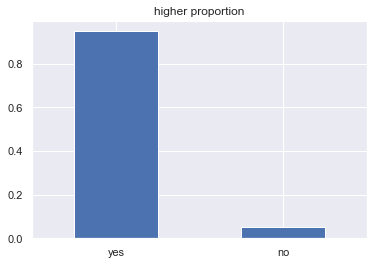

In [105]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'failures'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'higher'**: **20** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"failures"**. Наиболее сильная статистически значимая связь с **"failures"**, **"paid"**, **"m_edu"**, **"age"**.

Только **5 %** учеников **не хотели бы иметь высшее образование**. Данная колонка не рекомендуется для выявления рисков, так как размер выборки со значением "no" - 20, что меньше 30.

### internet
Наличие интернета дома: **yes** или **no**

Количество None-пропусков: 34
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 8.6%

Состав колонки internet


total  proportion
yes    305    0.844875
no      56    0.155125

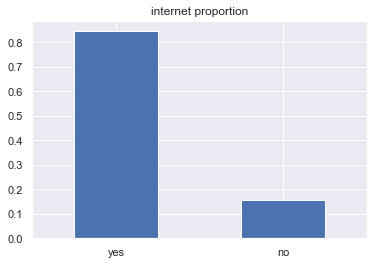

In [106]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'internet'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [107]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
29  union_edu     True      0.8333         4.334          3.637
6       m_edu     True      0.8333         4.319          3.621
3      adress     True      1.0000         3.472          3.472
8       m_job     True      0.8000         2.966          2.203
17       paid     True      1.0000         2.003          2.003

In [108]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['adress', 'paid', 'm_edu']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки internet


total  proportion
yes    305    0.844875
no      56    0.155125




1) Распределение значений колонки adress по значениям изучаемой колонки internet


adress           R         U
internet                    
no        0.296296  0.114286
yes       0.703704  0.885714


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки internet по значениям колонки adress


adress
U  0.823529
R  0.176471




2) Распределение значений колонки paid по значениям изучаемой колонки internet


paid            no       yes
internet                    
no        0.209184  0.090909
yes       0.790816  0.909091


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки internet по значениям колонки paid


paid
no   0.794118
yes  0.205882




3) Распределение значений колонки m_edu по значениям изучаемой колонки internet


m_edu            0         1         2         3
internet                                        
no        0.315789  0.153846  0.175824  0.065574
yes       0.684211  0.846154  0.824176  0.934426


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки internet по значениям колонки m_edu


m_edu
1  0.323529
3  0.294118
2  0.235294
0  0.147059

Заполним пропуски на основании m_edu

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки internet


total  proportion
yes    333    0.843038
no      62    0.156962

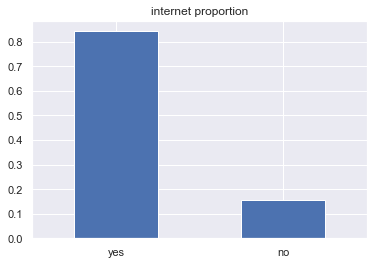

In [109]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'm_edu'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'internet'**: **34** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_edu"**. Наиболее сильная статистически значимая связь с **"adress"**, **"paid"**, **"m_edu"**.

У большинства учеников **есть интернет**.

### romantic 
В романтических отношениях: **yes** или **no**

In [ ]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'romantic'
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [112]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
1         sex     True      1.0000         1.289          1.289
28  age_categ     True      0.6667         1.264          1.016
20     higher     True      1.0000         0.914          0.914
27      score     True      0.3529         2.287          0.892
14   failures     True      0.3333         0.790          0.790

In [113]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['sex', 'failures', 'guardian']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки romantic


total  proportion
no     240    0.659341
yes    124    0.340659




1) Распределение значений колонки sex по значениям изучаемой колонки romantic


sex         F         M
romantic               
no        0.6  0.727811
yes       0.4  0.272189


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки romantic по значениям колонки sex


sex
M  0.580645
F  0.419355




2) Распределение значений колонки failures по значениям изучаемой колонки romantic


failures         0         1    2
romantic                         
no        0.687719  0.595745  0.5
yes       0.312281  0.404255  0.5


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки romantic по значениям колонки failures


failures
0  0.806452
1  0.161290
2  0.032258




3) Распределение значений колонки guardian по значениям изучаемой колонки romantic


guardian    other    parent
romantic                   
no        0.53125  0.671687
yes       0.46875  0.328313


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки romantic по значениям колонки guardian


guardian
parent       1.0

Ввиду отсутствия наиболее связанных параметров среди Nonе, заполним пропуски посредством колонки 'sex'.

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки romantic


total  proportion
no     263    0.665823
yes    132    0.334177

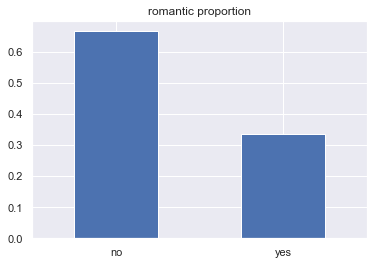

In [114]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'sex'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'romantic'**: **31** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"sex"**. Наиболее сильная статистически значимая связь с **"sex"**, **"higher"**, **"age_categ"**, **"failures"**, **"score"**.

Большинство студентов **не находится в романтических отношениях** (или скрывают их - скрытые пропуски)

### famrel
Cемейные отношения: от **1** - очень плохо до **5** - очень хорошо

Преобразовано в: от **0** - плохо до **2** - очень хорошо

In [115]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'famrel'
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 27
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 6.8%

Состав колонки famrel


total  proportion
 4.0    182    0.494565
 5.0     99    0.269022
 3.0     62    0.168478
 2.0     17    0.046196
 1.0      7    0.019022
-1.0      1    0.002717

Видим, что имеет место значение "-1", не соответствующее диапазону (1..5). Оно может как соответствовать "1", то есть написано с опечаткой, так и обозначать пропуск. Рассмотрим его и сравним с значениями "1-2".

In [116]:
display(stud[stud[column] == -1])
display(stud[stud[column].isin([1,2])].sort_values([column]).head(10))

school sex  age adress famsize p_status  m_edu  f_edu     m_job     f_job  \
25     GP   F   16      U     GT3        T      1      1  services  services   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
25   home   parent           0          0         2        no    yes  yes   

   activities nursery higher internet romantic  famrel  freetime  goout  \
25         no      no    yes      yes       no    -1.0       2.0    2.0   

    health_level  absences  score         age_categ  union_edu  
25           5.0      14.0   40.0  (14.994, 16.667]          1

school sex  age adress famsize p_status  m_edu  f_edu     m_job     f_job  \
184     GP   F   16      U     GT3        T      2      1     other     other   
357     MS   F   17      U     LE3        T      2      1  services     other   
299     GP   M   18      U     LE3        T      3      3   teacher   teacher   
66      GP   M   15      U     GT3        A      3      3     other  services   
108     GP   M   15      R     GT3        T      3      3     other     other   
389     MS   F   18      U     GT3        T      0      0     other     other   
207     GP   F   16      U     GT3        T      3      2   teacher     other   
363     MS   F   17      U     LE3        T      3      3   at_home   teacher   
296     GP   F   19      U     GT3        T      3      3    health     other   
278     GP   F   18      U     GT3        T      3      3    health     other   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
184  reputation   parent           0          1         0        no    yes   
357  reputation   parent           1          1         0        no     no   
299        home   parent           0          0         0        no    yes   
66   reputation   parent           0          2         0        no    yes   
108        home   parent           2          2         0        no    yes   
389      course   parent           0          1         1        no     no   
207       other   parent           0          1         0        no     no   
363        home   parent           0          1         0        no    yes   
296  reputation    other           1          1         0        no    yes   
278  reputation   parent           0          1         1       yes    yes   

    paid activities nursery higher internet romantic  famrel  freetime  goout  \
184   no         no     yes    yes      yes       no     1.0       2.0    2.0   
357   no         no     yes    yes       no      yes     1.0       2.0    3.0   
299  yes         no     yes    yes      yes      yes     1.0       4.0    2.0   
66    no        yes      no    yes      yes      yes     1.0       3.0    3.0   
108  yes        yes     yes    yes      yes      yes     1.0       3.0    5.0   
389   no        yes     yes    yes      yes       no     1.0       1.0    1.0   
207  yes         no     yes    yes      yes      yes     1.0       3.0    2.0   
363  yes        yes     yes    yes      yes      yes     2.0       3.0    4.0   
296  yes        yes     yes    yes      yes       no     2.0       3.0    4.0   
278   no        yes     yes    yes      yes      yes     2.0       4.0    4.0   

     health_level  absences  score         age_categ  union_edu  
184           1.0      14.0   60.0  (14.994, 16.667]          2  
357           5.0       2.0   55.0  (16.667, 18.333]          2  
299           1.0       5.0   80.0  (16.667, 18.333]          3  
66            3.0       4.0   60.0  (14.994, 16.667]          3  
108           1.0       6.0   65.0  (14.994, 16.667]          3  
389           5.0       0.0    0.0  (16.667, 18.333]          0  
207           1.0      10.0   65.0  (14.994, 16.667]          3  
363           1.0       0.0   75.0  (16.667, 18.333]          3  
296           2.0       0.0    0.0    (18.333, 20.0]          3  
278           4.0      15.0   40.0  (16.667, 18.333]          3

Ввиду отсутствия различий у "-1" с показателями в других столбцах у строк с значением "1", заполним его как "1"

In [117]:
stud[column].replace(-1,1, inplace=True)

# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 27
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 6.8%

Состав колонки famrel


total  proportion
4.0    182    0.494565
5.0     99    0.269022
3.0     62    0.168478
2.0     17    0.046196
1.0      8    0.021739

In [118]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row
    elif (row in [1,2,3]):
        return 0
    else:
        return row - 3
stud[column] = stud[column].apply(refilling_col) 

Количество None-пропусков: 27
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 6.8%

Состав колонки famrel


total  proportion
1.0    182    0.494565
2.0     99    0.269022
0.0     87    0.236413

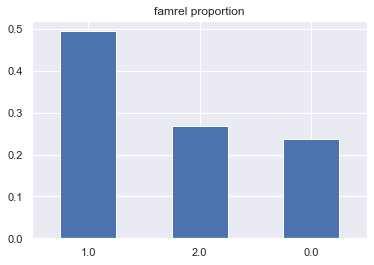

In [119]:
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [120]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
2        age     True      0.3556         3.320          2.401
23  freetime     True      0.3333         1.357          0.891
11  guardian     True      0.3333         0.778          0.778
14  failures     True      0.6667         1.137          0.731
22  romantic     True      0.6667         0.791          0.655

In [121]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['age', 'freetime', 'failures']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки famrel


total  proportion
1.0    182    0.494565
2.0     99    0.269022
0.0     87    0.236413




1) Распределение значений колонки age по значениям изучаемой колонки famrel


age           15        16        17        18        19   20
famrel                                                       
0.0     0.229730  0.291262  0.247191  0.175676  0.217391  0.0
1.0     0.472973  0.466019  0.505618  0.527027  0.652174  0.0
2.0     0.297297  0.242718  0.247191  0.297297  0.130435  1.0


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки famrel по значениям колонки age


age
17  0.333333
18  0.296296
15  0.296296
19  0.037037
16  0.037037




2) Распределение значений колонки freetime по значениям изучаемой колонки famrel


freetime       1.0       2.0       3.0       4.0       5.0
famrel                                                    
0.0       0.470588  0.355932  0.226950  0.190476  0.138889
1.0       0.411765  0.406780  0.517730  0.485714  0.555556
2.0       0.117647  0.237288  0.255319  0.323810  0.305556


Количество строк с пропусками в обеих колонках: 1

Состав для None-значений изучаемой колонки famrel по значениям колонки freetime


freetime
3.0  0.461538
4.0  0.269231
2.0  0.153846
5.0  0.076923
1.0  0.038462




3) Распределение значений колонки failures по значениям изучаемой колонки famrel


failures         0         1         2
famrel                                
0.0       0.245675  0.145833  0.290323
1.0       0.477509  0.666667  0.387097
2.0       0.276817  0.187500  0.322581


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки famrel по значениям колонки failures


failures
0  0.777778
1  0.148148
2  0.074074

Заполним пропуски на основе колонки "failures"

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки famrel


total  proportion
1    196    0.496203
2    107    0.270886
0     92    0.232911

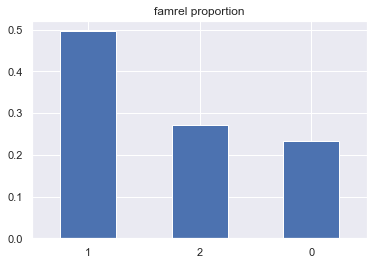

In [122]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'failures'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

# Изменим тип на int
stud[column] = stud[column].astype(int)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'famrel'**: **27** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_edu"**. Наиболее сильная статистически значимая связь с **"failures"**, **"guardian"**, **"age"**.

Чаще всего семейные отношения **"хорошие"**

### freetime

Свободное время после школы: от **1** - очень мало до **5** - очень много

Преобразовано ниже в: от **0** - мало до **3** - очень много

In [123]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'freetime'
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 11
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 2.8%

Состав колонки freetime


total  proportion
3.0    153    0.398438
4.0    112    0.291667
2.0     63    0.164062
5.0     38    0.098958
1.0     18    0.046875

In [124]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row
    elif (row == 1) or (row == 2):
        return 0
    else:
        return row - 2
stud[column] = stud[column].apply(refilling_col) 

Количество None-пропусков: 11
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 2.8%

Состав колонки freetime


total  proportion
1.0    153    0.398438
2.0    112    0.291667
0.0     81    0.210938
3.0     38    0.098958

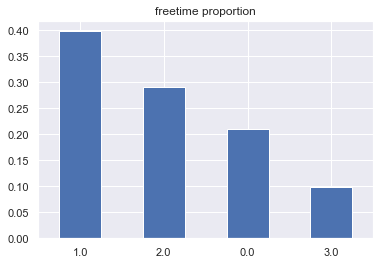

In [125]:
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [126]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
24      goout     True      0.6750         6.069          4.641
1         sex     True      1.0000         3.562          2.961
8       m_job     True      0.4250         2.802          1.632
21   internet     True      0.5000         1.570          1.285
13  studytime     True      0.1667         1.303          1.213

In [127]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['sex', 'goout', 'm_job']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки freetime


total  proportion
1.0    153    0.398438
2.0    112    0.291667
0.0     81    0.210938
3.0     38    0.098958




1) Распределение значений колонки sex по значениям изучаемой колонки freetime


sex           F         M
freetime                 
0.0       0.255  0.163043
1.0       0.450  0.342391
2.0       0.255  0.331522
3.0       0.040  0.163043


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки freetime по значениям колонки sex


sex
F  0.727273
M  0.272727




2) Распределение значений колонки goout по значениям изучаемой колонки freetime


goout          1.0       2.0       3.0       4.0       5.0
freetime                                                  
0.0       0.409091  0.340206  0.170732  0.146341  0.096154
1.0       0.227273  0.402062  0.528455  0.304878  0.269231
2.0       0.181818  0.185567  0.268293  0.475610  0.326923
3.0       0.181818  0.072165  0.032520  0.073171  0.307692


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки freetime по значениям колонки goout


goout
3.0  0.363636
2.0  0.363636
4.0  0.181818
1.0  0.090909




3) Распределение значений колонки m_job по значениям изучаемой колонки freetime


m_job      at_home    health     other  services   teacher
freetime                                                  
0.0       0.192982  0.294118  0.211679  0.217822  0.163636
1.0       0.561404  0.176471  0.416058  0.396040  0.327273
2.0       0.210526  0.441176  0.262774  0.267327  0.400000
3.0       0.035088  0.088235  0.109489  0.118812  0.109091


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки freetime по значениям колонки m_job


m_job
services  0.272727
at_home   0.272727
other     0.272727
teacher   0.181818

Наиболее логичной выглядит связь с "goout", заполним по ней

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки freetime


total  proportion
1    157    0.397468
2    116    0.293671
0     83    0.210127
3     39    0.098734

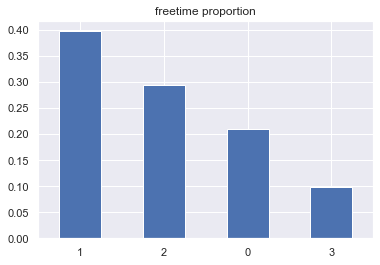

In [128]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'goout'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

# Изменим тип на int
stud[column] = stud[column].astype(int)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'freetime'**: **11** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"goout"**. Наиболее сильная статистически значимая связь с **"sex"**, **"goout"**, **"m_job"**.

В большинстве случаев у учеников имеется **"не мало"** свободного времени после школы

### goout
Проведение времени с друзьями: от **1** - очень мало до **5** - очень много

Преобразовано ниже: от **0** - мало до **3** - очень много

In [129]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'goout'
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 8
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 2.0%

Состав колонки goout


total  proportion
3.0    127    0.328165
2.0    101    0.260982
4.0     84    0.217054
5.0     52    0.134367
1.0     23    0.059432

In [130]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row
    elif (row == 1) or (row == 2):
        return 0
    else:
        return row - 2
stud[column] = stud[column].apply(refilling_col) 

In [131]:
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 8
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 2.0%

Состав колонки goout


total  proportion
1.0    127    0.328165
0.0    124    0.320413
2.0     84    0.217054
3.0     52    0.134367

In [132]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
24   freetime     True      0.7500         5.484          4.577
20     higher     True      0.2500         1.734          1.734
2         age     True      0.3667         2.542          1.288
28  age_categ     True      0.2500         1.594          1.167
14   failures     True      0.5000         1.776          1.153

In [133]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['freetime', 'health_level']

# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки goout


total  proportion
1.0    127    0.328165
0.0    124    0.320413
2.0     84    0.217054
3.0     52    0.134367




1) Распределение значений колонки freetime по значениям изучаемой колонки goout


freetime         0         1         2         3
goout                                           
0.0       0.536585  0.296053  0.200000  0.315789
1.0       0.256098  0.440789  0.304348  0.105263
2.0       0.146341  0.171053  0.347826  0.157895
3.0       0.060976  0.092105  0.147826  0.421053


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки goout по значениям колонки freetime


freetime
1     0.625
3     0.125
2     0.125
0     0.125




2) Распределение значений колонки health_level по значениям изучаемой колонки goout


health_level       1.0       2.0       3.0       4.0       5.0
goout                                                         
0.0           0.304348  0.219512  0.363636  0.163934  0.389706
1.0           0.282609  0.390244  0.409091  0.393443  0.257353
2.0           0.282609  0.219512  0.159091  0.295082  0.198529
3.0           0.130435  0.170732  0.068182  0.147541  0.154412


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки goout по значениям колонки health_level


health_level
4.0         0.250
2.0         0.250
5.0         0.250
3.0         0.125
1.0         0.125

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки goout


total  proportion
1    129    0.326582
0    125    0.316456
2     87    0.220253
3     54    0.136709

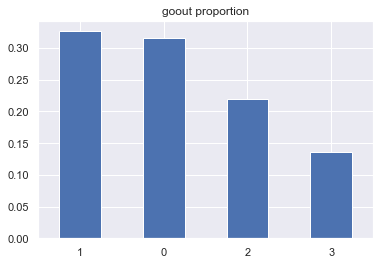

In [134]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'freetime'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

# Изменим тип на int
stud[column] = stud[column].astype(int)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'goout'**: **8** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"freetime"**. Наиболее сильная статистически значимая связь с **"freetime"**, **"failures"**, **"age/age_categ"**, **"health_level"**.

Время с друзьями ученики как правило проводят **не много**

### health_level
Текущее состояние здоровья: от **1** - очень плохо до **5** - очень хорошо

Преобразовано ниже в: от **0** - плохо до **2** - хорошо

In [135]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'health_level'
# Вывод состава колонки
compos = display_cat_compos(stud, column, plot=False)

Количество None-пропусков: 15
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 3.8%

Состав колонки health_level


total  proportion
5.0    138    0.363158
3.0     89    0.234211
4.0     63    0.165789
1.0     47    0.123684
2.0     43    0.113158

In [136]:
# Перезаполнение категорий
def refilling_col(row):
    if pd.isna(row):
        return row
    elif (row == 1) or (row == 2):
        return 0
    elif (row == 3) or (row == 4):
        return 1    
    else:
        return 2
stud[column] = stud[column].apply(refilling_col) 

Количество None-пропусков: 15
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 3.8%

Состав колонки health_level


total  proportion
1.0    152    0.400000
2.0    138    0.363158
0.0     90    0.236842

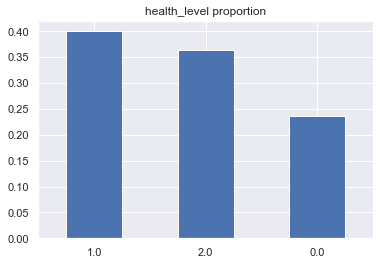

In [137]:
# Вывод состава колонки
compos = display_cat_compos(stud, column)

In [138]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
10     reason     True      0.4444         2.087          1.504
7       f_edu     True      0.5000         2.078          1.235
1         sex     True      1.0000         1.668          1.218
21   internet     True      0.6667         1.404          1.131
13  studytime     True      0.6667         1.173          1.009

In [139]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['reason', 'sex', 'goout']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column, sub_column_list, compos)


Состав колонки health_level


total  proportion
1.0    152    0.400000
2.0    138    0.363158
0.0     90    0.236842




1) Распределение значений колонки reason по значениям изучаемой колонки health_level


reason          course      home     other  reputation
health_level                                          
0.0           0.159420  0.252336  0.212121    0.333333
1.0           0.398551  0.392523  0.363636    0.421569
2.0           0.442029  0.355140  0.424242    0.245098


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки health_level по значениям колонки reason


reason
home        0.400000
course      0.266667
reputation  0.200000
other       0.133333




2) Распределение значений колонки sex по значениям изучаемой колонки health_level


sex                  F         M
health_level                    
0.0           0.267327  0.202247
1.0           0.435644  0.359551
2.0           0.297030  0.438202


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки health_level по значениям колонки sex


sex
M  0.6
F  0.4




3) Распределение значений колонки goout по значениям изучаемой колонки health_level


goout                0         1         2         3
health_level                                        
0.0           0.201681  0.230159  0.273810  0.274510
1.0           0.352941  0.484127  0.392857  0.313725
2.0           0.445378  0.285714  0.333333  0.411765


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки health_level по значениям колонки goout


goout
0    0.4
3    0.2
2    0.2
1    0.2

Наиболее показательна взаимосвязь с колонкой "reason"

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки health_level


total  proportion
1    158    0.400000
2    143    0.362025
0     94    0.237975

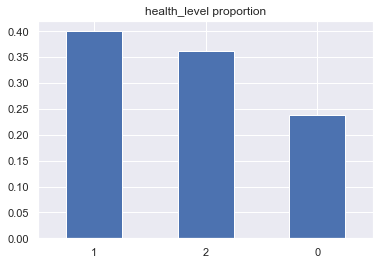

In [140]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'reason'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

# Изменим тип на int
stud[column] = stud[column].astype(int)

# Вывод состава колонки
compos = display_cat_compos(stud, column)

**Вывод по столбцу 'health_level'**: **15** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"famrel"**. Наиболее сильная статистически значимая связь с **"reason"**, **"sex"**, **"goout"**.

Большинство учеников имеют **"хорошее здоровые"**.

### absences
Количество пропущенных занятий, числовая колонка

Количество None-пропусков: 12
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 3.0%

Статистические характеристики колонки absences


absences
count  383.000000
mean     7.279373
std     23.465197
min      0.000000
25%      0.000000
50%      4.000000
75%      8.000000
max    385.000000


Количество выбросов: 17

Значения выбросов:


outliers_count
22.0                3
212.0               1
23.0                1
40.0                1
38.0                1
30.0                1
75.0                1
21.0                1
385.0               1
28.0                1
24.0                1
56.0                1
26.0                1
54.0                1
25.0                1

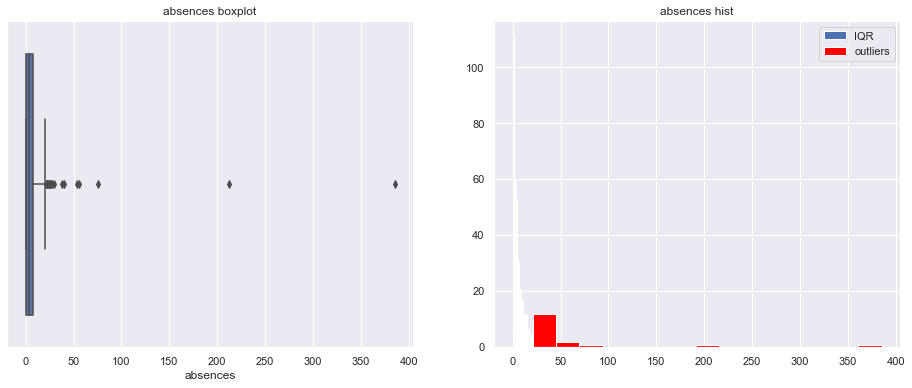

In [141]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ ЧИСЛОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'absences'
# Вывод состава колонки
compos = display_num_compos(stud, column)

В данной колонке кроме пропусков имеет место очень большое количество выбросов. C учётом применённого цикличного метода выявления выбросов выяснилось, что имеют место **12 пропусков** и **34 выброса**. Создадим отдельную колонку для отслеживания, какие данные были выбросами, какие - пропусками, а какие имели место изначально.

Выбросы же превратим в None-значения и заполним вместе с остальными пропусками методом "приписывания".

В вводимой колонке **"absences_flag"**: 'primary' - первоначальное значение сохранилось, 'outlier' - выброс, 'skip' - пропуск.  

In [142]:
# Найдём значение, начиная с которого значение будет считаться выбросом

# Будем вычислять выбросы до тех пор, пока лист с выбросами не очистится
# Необходимость выполнять в цикле связана с тем, что при каждом удалении происходит изменение квартилей,
# и поэтому значения, раньше не считавшиеся выбросами, становятся таковыми.

temp_df = stud.copy(deep=True)
compos = display_num_compos(temp_df, column, disp=False, plot=False)
out_count = 0
while len(compos['outliers']) > 0:
    out_count += compos['outliers'].sum()[0]
    max_val = mod_eda.get_boards(temp_df[column])[1] 
    temp_df = temp_df.drop(temp_df[temp_df[column].isin(list(compos['outliers'].index))].index)
    # Обновление сведений
    compos = display_num_compos(temp_df, column, disp=False, plot=False)
print(f'Количество выбросов: {out_count}. Максимальное предельное значение: {max_val}.') # Работает при выбросах справа

Количество выбросов: 35. Максимальное предельное значение: 15.0.


In [143]:
# Функция заполнения вспомогательной колонки, позволяющей отделять исходные данные от приобретённых
# Работает при выбросах справа 
def fill_absenc_flag(row):
    if pd.isna(row):
        return 'skip'
    elif row > max_val:
        return 'outlier'
    else:
        return 'primary'
#Заполним вспомогательную колонку
stud['absences_flag'] = stud['absences'].apply(fill_absenc_flag)  

In [144]:
stud['absences_flag'].value_counts()

primary    348
outlier     35
skip        12
Name: absences_flag, dtype: int64

Функция отработала корректно.

In [145]:
# Превратим выбросы в None:
stud['absences'] = stud['absences'].apply(lambda x: None if (x > max_val) else x)
# Обновление сведений
compos = display_num_compos(stud, column, plot=False)

Количество None-пропусков: 47
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 11.9%

Статистические характеристики колонки absences


absences
count  348.000000
mean     3.928161
std      4.061914
min      0.000000
25%      0.000000
50%      2.500000
75%      6.000000
max     15.000000


Выбросы не обнаружены


Количество None-пропусков: 47
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 11.9%

Статистические характеристики колонки absences


absences
count  348.000000
mean     3.928161
std      4.061914
min      0.000000
25%      0.000000
50%      2.500000
75%      6.000000
max     15.000000


Выбросы не обнаружены


age             0.111310
m_edu           0.100580
f_edu           0.040874
traveltime     -0.050436
studytime      -0.017831
failures        0.060605
famrel         -0.026525
freetime        0.031704
goout           0.103090
health_level   -0.047458
absences        1.000000
score           0.122554
union_edu       0.068793
Name: absences, dtype: float64

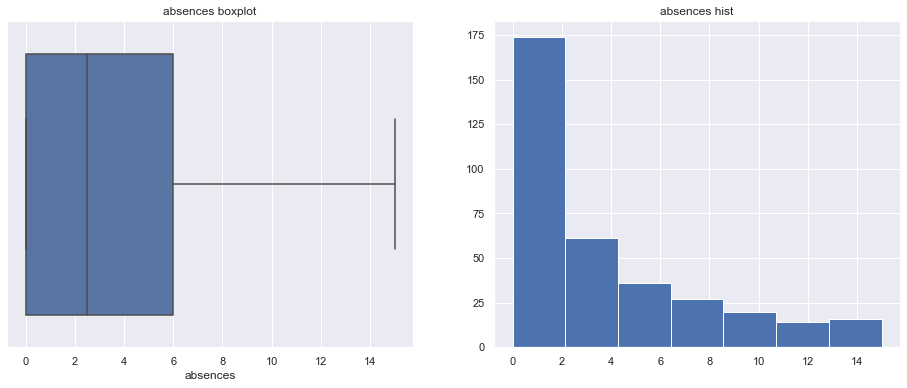

In [146]:
# Проанализируем состав без выбросов
compos = display_num_compos(stud, column, bin_koef=2)
# Оценим корреляцию
stud.corr()[column]

In [147]:
# ПРЕВРАЩЕНИЕ ЧИСЛОВОЙ КОЛОНКИ В КАТЕГОРИАЛЬНУЮ
stud[column+'_categ'] = mod_eda.change_num_to_count(stud, column, 3)
stud[column+'_categ'].value_counts()

(-0.016, 5.0]    240
(5.0, 10.0]       78
(10.0, 15.0]      30
Name: absences_categ, dtype: int64

In [148]:
# Составим список взаимосвязанных колонок с исходной колонкой 
column = 'absences'
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column)
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
3     adress     True      0.1250         3.385          3.084
25     goout     True      0.0729         2.127          1.317
6      m_edu     True      0.0625         1.968          1.235
23    famrel     True      0.0625         1.371          0.946
5   p_status     True      0.0625         0.891          0.891

Количество None-пропусков: 47
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 11.9%

Состав колонки absences_categ


total  proportion
(-0.016, 5.0]    240    0.689655
(5.0, 10.0]       78    0.224138
(10.0, 15.0]      30    0.086207

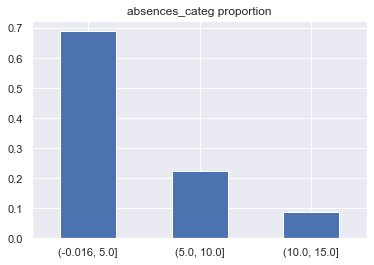

In [149]:
# Найдём колонки, связанные с новой "категориальной" колонкой пропуска занятий
compos = display_cat_compos(stud, column+'_categ')

In [150]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column+'_categ')
display(depends_col.head(5))

col_name  depends  rel_amount  max_log_frac  log_mean_frac
28     score     True      0.1201         7.572          5.884
14  failures     True      0.1111         1.736          1.736
10    reason     True      0.5000         2.381          1.693
5   p_status     True      0.6667         1.541          1.376
20    higher     True      0.3333         1.284          1.284

In [151]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['failures', 'goout', 'higher']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column+'_categ', sub_column_list, compos)


Состав колонки absences_categ


total  proportion
(-0.016, 5.0]    240    0.689655
(5.0, 10.0]       78    0.224138
(10.0, 15.0]      30    0.086207




1) Распределение значений колонки failures по значениям изучаемой колонки absences_categ


failures               0         1         2
absences_categ                              
(-0.016, 5.0]   0.705674  0.615385  0.629630
(5.0, 10.0]     0.226950  0.179487  0.259259
(10.0, 15.0]    0.067376  0.205128  0.111111


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки absences_categ по значениям колонки failures


failures
0  0.595745
1  0.276596
2  0.127660




2) Распределение значений колонки goout по значениям изучаемой колонки absences_categ


goout                  0         1         2         3
absences_categ                                        
(-0.016, 5.0]   0.747748  0.689076  0.621622  0.659091
(5.0, 10.0]     0.162162  0.252101  0.283784  0.204545
(10.0, 15.0]    0.090090  0.058824  0.094595  0.136364


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки absences_categ по значениям колонки goout


goout
0  0.297872
2  0.276596
3  0.212766
1  0.212766




3) Распределение значений колонки higher по значениям изучаемой колонки absences_categ


higher           no       yes
absences_categ               
(-0.016, 5.0]   1.0  0.676647
(5.0, 10.0]     0.0  0.233533
(10.0, 15.0]    0.0  0.089820


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки absences_categ по значениям колонки higher


higher
yes  0.87234
no   0.12766

Заполним недостающие категории на основе колонки "failures"

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Состав колонки absences_categ


total  proportion
(-0.016, 5.0]    276    0.698734
(5.0, 10.0]       83    0.210127
(10.0, 15.0]      36    0.091139

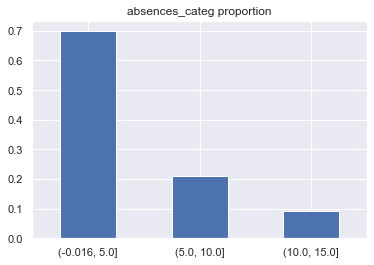

In [152]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'failures'

# Осуществим заполнение пропусков методом "приписывания"
stud[column+'_categ'] = mod_eda.fill_rand(stud[column+'_categ'], stud[sub_column])

# Вывод состава колонки
compos = display_cat_compos(stud, column+'_categ')

Теперь на основе заполненной выше колонки "absences_categ" заполним пропуски в колонке "absences".

Количество None-пропусков: 47
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 11.9%

Статистические характеристики колонки absences


absences
count  348.000000
mean     3.928161
std      4.061914
min      0.000000
25%      0.000000
50%      2.500000
75%      6.000000
max     15.000000


Выбросы не обнаружены


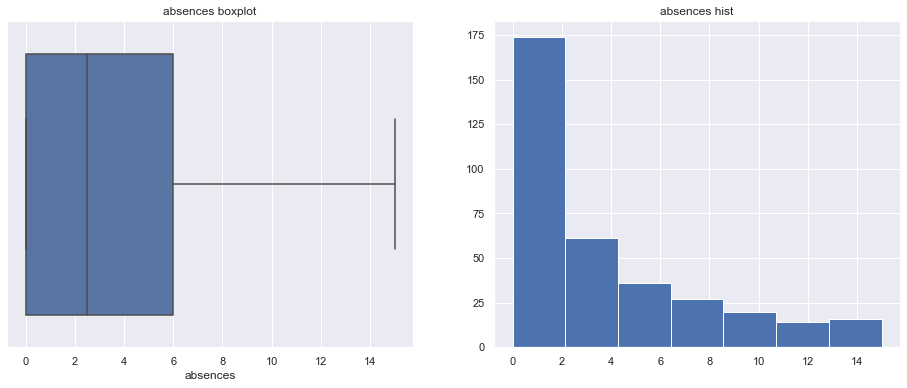

In [153]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ ЧИСЛОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'absences'
# Вывод состава колонки
compos = display_num_compos(stud, column, bin_koef=2)

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Статистические характеристики колонки absences


absences
count  395.000000
mean     3.921519
std      4.080586
min      0.000000
25%      0.000000
50%      2.000000
75%      6.000000
max     15.000000


Выбросы не обнаружены


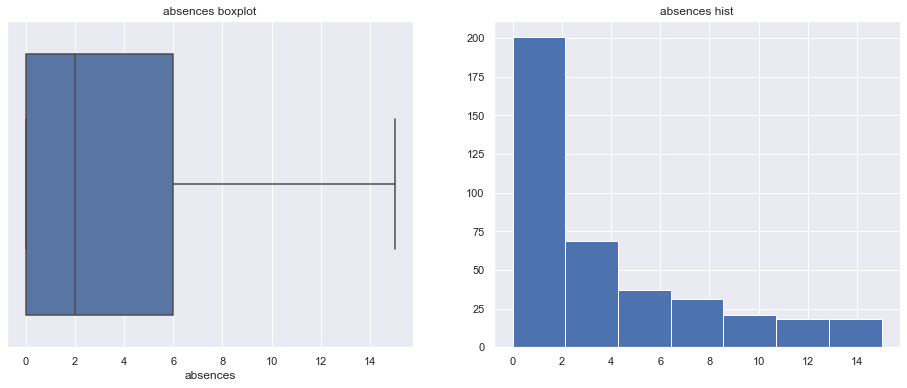

In [154]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'absences_categ'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])
# Вывод состава колонки
compos = display_num_compos(stud, column, bin_koef=2)

**Вывод по столбцу 'absences'**: имеют место **12 пропусков** и **34 выброса**. Выбросы были превращены в None-значения и были заполнены с остальными пропусками. Для заполнения None была созданная отдельная колонка "absences_categ", а для отслеживания, какие данные исходные, а какие искусственные - "absences_flag" ('primary' - первоначальное значение сохранилось, 'outlier' - выброс, 'skip' - пропуск.).

Колонка **"absences_categ"** наиболее сильно взаимосвязана со **"score"**, **"failures"**, **"goout"**.
Колонка **"absences"** наиболее сильно взаимосвязана с **"adress"**, **"m_edu"**, **"goout"**.

Чаще всего студенты **редко пропускают занятия**.

### score
Баллы по госэкзамену по математике (целевой параметр)

Количество None-пропусков: 6
Пробельные пропуски отсутствуют.

Доля пропусков от объёма выборки: 1.5%

Статистические характеристики колонки score


score
count  389.000000
mean    52.262211
std     22.919022
min      0.000000
25%     40.000000
50%     55.000000
75%     70.000000
max    100.000000


Выбросы не обнаружены


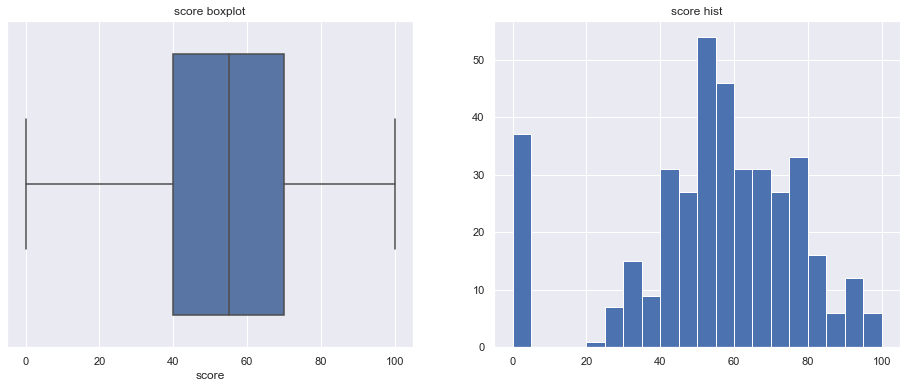

In [155]:
# ОЗНАКОМЛЕНИЕ С СОСТАВОМ ЧИСЛОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'score'
# Вывод состава колонки
compos = display_num_compos(stud, column, bin_koef=5)

Особенностью анализа последней колонки является то, что она - целевой параметр обучения модели, а 0 характеризует несдачу экзамена.

Оценим состав колонки без 0

None-пропуски отсутствуют.
Пробельные пропуски отсутствуют.

Статистические характеристики колонки score


score
count  352.000000
mean    57.755682
std     16.200928
min     20.000000
25%     45.000000
50%     55.000000
75%     70.000000
max    100.000000


Выбросы не обнаружены


50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

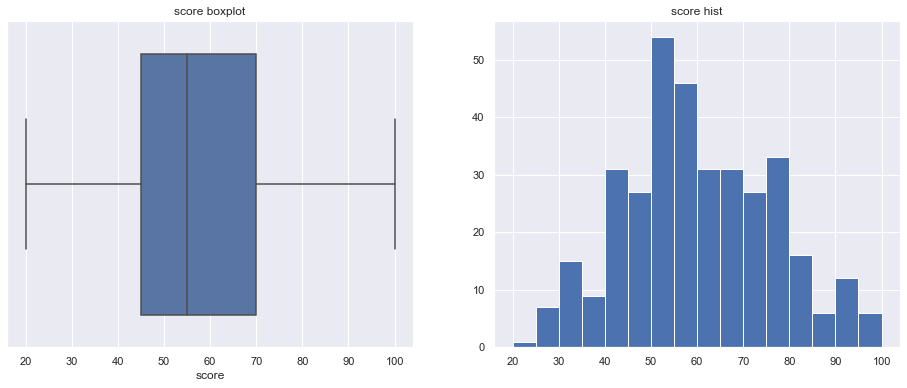

In [156]:
# Вывод состава колонки
compos = display_num_compos(stud[stud[column] > 0], column, bin_koef=5)
stud[column].value_counts()

Баллы по математике представляют собой дискретный ряд с **шагом в 5 баллов**. При этом **порог** успешной сдачи - **20 баллов**, поэтому значение **"0"**, по всей видимости, соответствует **проваленному экзамену** с баллами в диапазоне от **0 до 15**. При анализе всей совокупности данных показателя "score" значение "0" **не является выбросом**. Однако если первоначальное распределение было ненулевым (см. распределение без 0), то посчитанная нижняя граница выбросов оказывается больше 0, и тогда значение "0" можно было бы считать выбросом. Остановимся на первом варианте интерпретации значений

Таким образом, 9% от числа непропущенных данных - провальные. Удалить эти сведения, или заменить на соответствующие диапазону в границах выбросов не представляется возможным, так как они имеют важную смысловую нагрузку.

Оценим теперь состав пропущенных значений в показателе "score" и решим, что с ними делать дальше, удалять или заполнить особым образом, например значением "0", если высока вероятность, что так и есть (на основе анализа взаимосвязи с другими колонками). 

Так как заполнение пропусков методом "приписывания" может привести к искажению результатов работы модели, ввиду создания заведомой зависимости пропущенных сведений с некоторой колонкой, применять его нецелесообразно.

In [157]:
stud[stud[column].isna()]

school sex  age adress famsize p_status  m_edu  f_edu  m_job     f_job  \
201     GP   F   16      U     GT3        T      1      2  other     other   
244     GP   F   18      U     GT3        T      1      0  other     other   
270     GP   F   19      U     GT3        T      2      2  other  services   
283     GP   F   18      U     GT3        T      0      0  other     other   
312     GP   M   19      U     GT3        T      0      1  other  services   
350     MS   M   19      R     GT3        T      0      0  other  services   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
201  reputation   parent           0          1         0       yes    yes   
244      course    other           1          2         0        no    yes   
270        home    other           0          1         2        no    yes   
283        home   parent           1          1         0       yes     no   
312      course    other           0          1         1        no     no   
350        home    other           2          1         2        no     no   

    paid activities nursery higher internet romantic  famrel  freetime  goout  \
201  yes        yes     yes    yes       no       no       1         2      1   
244  yes         no      no    yes      yes      yes       1         2      2   
270  yes        yes     yes    yes      yes       no       1         1      3   
283   no        yes     yes    yes      yes       no       2         1      2   
312   no         no      no    yes      yes       no       1         3      3   
350   no         no     yes    yes      yes       no       2         2      2   

     health_level  absences  score         age_categ  union_edu absences_flag  \
201             1       6.0    NaN  (14.994, 16.667]          2       primary   
244             1       0.0    NaN  (16.667, 18.333]          1       primary   
270             2       0.0    NaN    (18.333, 20.0]          2          skip   
283             1       4.0    NaN  (16.667, 18.333]          0       primary   
312             1       3.0    NaN    (18.333, 20.0]          1       primary   
350             0       8.0    NaN    (18.333, 20.0]          0       primary   

    absences_categ  
201    (5.0, 10.0]  
244  (-0.016, 5.0]  
270  (-0.016, 5.0]  
283  (-0.016, 5.0]  
312  (-0.016, 5.0]  
350    (5.0, 10.0]

In [158]:
stud[stud[column] == 0].head(10)

school sex  age adress famsize p_status  m_edu  f_edu     m_job     f_job  \
128     GP   M   18      R     GT3        T      1      1   at_home     other   
130     GP   F   15      R     GT3        T      2      3  services   teacher   
131     GP   F   15      U     GT3        T      0      0   at_home     other   
134     GP   M   15      R     GT3        T      2      3   at_home   teacher   
135     GP   F   15      U     GT3        T      3      3  services  services   
136     GP   M   17      R     GT3        T      2      3   at_home     other   
137     GP   F   16      U     GT3        A      2      3     other     other   
140     GP   M   15      U     GT3        T      3      2   teacher  services   
144     GP   M   17      U     GT3        T      1      0     other     other   
146     GP   F   15      U     GT3        T      2      1    health  services   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
128  reputation   parent           0          0         2        no    yes   
130      course   parent           1          2         2        no    yes   
131      course   parent           2          0         0        no    yes   
134      course   parent           0          1         0        no    yes   
135      course   parent           0          2         0        no    yes   
136      course   parent           2          1         0        no     no   
137        home    other           1          0         2        no    yes   
140        home   parent           1          2         0       yes    yes   
144        home   parent           0          0         2        no    yes   
146        home   parent           0          1         2        no    yes   

    paid activities nursery higher internet romantic  famrel  freetime  goout  \
128   no        yes     yes    yes      yes       no       0         1      1   
130   no         no     yes    yes      yes      yes       1         0      0   
131   no        yes      no    yes      yes      yes       1         1      1   
134   no         no     yes    yes       no      yes       2         1      1   
135   no        yes     yes    yes      yes      yes       1         1      1   
136   no         no     yes    yes       no       no       1         2      3   
137   no        yes      no    yes      yes      yes       1         1      0   
140   no        yes     yes    yes      yes       no       0         0      0   
144   no         no     yes    yes      yes       no       2         2      3   
146   no         no     yes    yes      yes       no       0         1      0   

     health_level  absences  score         age_categ  union_edu absences_flag  \
128             1       0.0    0.0  (16.667, 18.333]          1       primary   
130             2       0.0    0.0  (14.994, 16.667]          3       primary   
131             1       0.0    0.0  (14.994, 16.667]          0       primary   
134             2       0.0    0.0  (14.994, 16.667]          3       primary   
135             2       0.0    0.0  (14.994, 16.667]          3       primary   
136             2       0.0    0.0  (16.667, 18.333]          3       primary   
137             2       0.0    0.0  (14.994, 16.667]          3       primary   
140             1       0.0    0.0  (14.994, 16.667]          3       primary   
144             2       0.0    0.0  (16.667, 18.333]          1       primary   
146             1       0.0    0.0  (14.994, 16.667]          2       primary   

    absences_categ  
128  (-0.016, 5.0]  
130  (-0.016, 5.0]  
131  (-0.016, 5.0]  
134  (-0.016, 5.0]  
135  (-0.016, 5.0]  
136  (-0.016, 5.0]  
137  (-0.016, 5.0]  
140  (-0.016, 5.0]  
144  (-0.016, 5.0]  
146  (-0.016, 5.0]

Проанализируем данную колонку аналогично предыдущей, создав на её основе категориальную копию

In [159]:
#ПРЕВРАЩЕНИЕ ЧИСЛОВОЙ КОЛОНКИ В КАТЕГОРИАЛЬНУЮ
stud[column+'_categ'] = mod_eda.change_num_to_count(stud, column, 3)
stud[column+'_categ'].value_counts()

(33.333, 66.667]    229
(66.667, 100.0]     100
(-0.101, 33.333]     60
Name: score_categ, dtype: int64

In [160]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
depends_col = mod_eda.find_depends_col(stud, column+'_categ')
display(depends_col[depends_col['depends']])

col_name  depends  rel_amount  max_log_frac  log_mean_frac
14        failures     True      0.5556         3.688          2.991
6            m_edu     True      0.5556         3.767          2.820
30       union_edu     True      0.5556         3.283          2.391
17            paid     True      0.6667         2.500          2.208
9            f_job     True      0.4444         2.384          2.134
13       studytime     True      0.5556         2.526          1.866
2              age     True      0.2889         2.070          1.346
8            m_job     True      0.4667         2.030          1.131
15       schoolsup     True      0.3333         1.019          1.019
3           adress     True      0.6667         1.264          0.988
26    health_level     True      0.4444         1.280          0.971
29       age_categ     True      0.4444         1.267          0.865
11        guardian     True      0.3333         0.856          0.856
12      traveltime     True      0.5556         1.297          0.765
25           goout     True      0.3333         1.225          0.687
10          reason     True      0.2222         1.098          0.595
7            f_edu     True      0.5000         1.232          0.582
1              sex     True      0.6667         0.767          0.565
20          higher     True      0.3333         0.496          0.496
32  absences_categ     True      0.5556         0.929          0.496
31   absences_flag     True      0.2222         0.541          0.487
24        freetime     True      0.1111         0.445          0.379
0           school     True      0.6667         0.312          0.233
21        internet     True      0.6667         0.170          0.149
4          famsize     True      0.6667         0.213          0.149
22        romantic     True      0.6667         0.112          0.100
23          famrel     True      0.1111         0.032          0.032

In [161]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ КОЛОНКАМИ
# Список колонок для анализа
sub_column_list = ['failures', 'f_job', 'schoolsup', 'romantic', 'absences_categ', 'paid', 'goout']
# Вывод данных по оценке взаимосвязи между колонками
col_relation = display_col_relation(stud, column+'_categ', sub_column_list, compos)


Состав колонки score_categ


score
count  352.000000
mean    57.755682
std     16.200928
min     20.000000
25%     45.000000
50%     55.000000
75%     70.000000
max    100.000000




1) Распределение значений колонки failures по значениям изучаемой колонки score_categ


failures                 0         1         2
score_categ                                   
(-0.101, 33.333]  0.117264  0.235294  0.387097
(33.333, 66.667]  0.566775  0.725490  0.580645
(66.667, 100.0]   0.315961  0.039216  0.032258


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки score_categ по значениям колонки failures


failures
0  0.500000
2  0.333333
1  0.166667




2) Распределение значений колонки f_job по значениям изучаемой колонки score_categ


f_job               other  services   teacher
score_categ                                  
(-0.101, 33.333]  0.15261  0.155963  0.161290
(33.333, 66.667]  0.60241  0.633028  0.322581
(66.667, 100.0]   0.24498  0.211009  0.516129


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки score_categ по значениям колонки f_job


f_job
services    0.5
other       0.5




3) Распределение значений колонки schoolsup по значениям изучаемой колонки score_categ


schoolsup               no       yes
score_categ                         
(-0.101, 33.333]  0.148810  0.188679
(33.333, 66.667]  0.565476  0.735849
(66.667, 100.0]   0.285714  0.075472


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки score_categ по значениям колонки schoolsup


schoolsup
no    0.666667
yes   0.333333




4) Распределение значений колонки romantic по значениям изучаемой колонки score_categ


romantic                no      yes
score_categ                        
(-0.101, 33.333]  0.135659  0.19084
(33.333, 66.667]  0.585271  0.59542
(66.667, 100.0]   0.279070  0.21374


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки score_categ по значениям колонки romantic


romantic
no   0.833333
yes  0.166667




5) Распределение значений колонки absences_categ по значениям изучаемой колонки score_categ


absences_categ    (-0.016, 5.0]  (5.0, 10.0]  (10.0, 15.0]
score_categ                                               
(-0.101, 33.333]       0.176471     0.098765      0.111111
(33.333, 66.667]       0.551471     0.641975      0.750000
(66.667, 100.0]        0.272059     0.259259      0.138889


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки score_categ по значениям колонки absences_categ


absences_categ
(-0.016, 5.0]        0.666667
(5.0, 10.0]          0.333333




6) Распределение значений колонки paid по значениям изучаемой колонки score_categ


paid                    no       yes
score_categ                         
(-0.101, 33.333]  0.209091  0.082840
(33.333, 66.667]  0.540909  0.650888
(66.667, 100.0]   0.250000  0.266272


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки score_categ по значениям колонки paid


paid
no    0.5
yes   0.5




7) Распределение значений колонки goout по значениям изучаемой колонки score_categ


goout                 0         1         2         3
score_categ                                          
(-0.101, 33.333]  0.144  0.117188  0.154762  0.269231
(33.333, 66.667]  0.576  0.578125  0.642857  0.557692
(66.667, 100.0]   0.280  0.304688  0.202381  0.173077


Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки score_categ по значениям колонки goout


goout
2  0.500000
3  0.333333
1  0.166667

Проведённый выше анализ показал, что **предположение** о том, что показатели учеников с пропуском значения "score" сходны с показателями учеников, имеющих "0", **неверно**. Но всё равно заполним пропуски значениями **"0"** и создадим **бинарную колонку**, характеризующую, являются ли баллы по математике исходными значениями, или нет.

Такой подход применяется несмотря на то, что пропусков всего **6**, так как данная колонка является целевой, и хотелось бы отделить истинные значения от заполненных искусственно.

In [162]:
stud[column+'_flag'] = stud[column].apply(lambda x: False if pd.isna(x) else True)
stud[column+'_flag'].value_counts()
stud[column+'_categ'].fillna(pd.Interval(0,0), inplace=True)
stud[column].fillna(0, inplace=True)

In [163]:
# ПРОВЕРИМ, ЕСТЬ ЛИ ХОТЬ ОДИН ПРОПУСК В ПОЛУЧИВШИМСЯ ДАТАФРЕЙМЕ
stud.isnull().values.any()

False

## Выводы по разделу "Анализ данных в столбцах"
Проведённый анализ данных в столбцах позволил:
- **устранить выбросы** для числовых переменных;
- **оценить количество** уникальных значений категориальных переменных, **объединив** уникальные значения ранговых переменных с малой пропорцией с близкими и **преобразовав** те, что не соответствовали обозначенным в задании категориям, или не имели логического смысла;
- **найти взаимосвязанные колонки** и оценить степень их связи;
- **устранить все пропуски**, заполнив их (за исключением "score") методом приписывания;
- **сделать выводы** по каждой из колонок:

### Новое описание колонок:

1 **school** — аббревиатура школы, в которой учится ученик;

- **Вывод по столбцу 'school'**: Пропуски в данном столбце отсутствуют. Около *88%* студентов выборки (общим размером *395* человек) обучаются в школе **"GP"**.
  
2 **sex** — пол ученика (**'F'** - женский, **'M'** - мужской);

- **Вывод по столбцу 'sex'**: В данном столбце пропусков нет. Имеется небольшой **перевес**, порядка 5% **в пользу количества девочек** в выборке.

3 **age** — возраст ученика (от **15** до **20**);

- **Вывод по столбцу 'age'**: В данном столбце отсутствуют пропуски. Возраст студентов имеет близкое к нормальному распределение. **Устранён** один **выброс - 22 года**. Введён возраст "20", вбирающий в себя от 20 лет

4 **address** — тип адреса ученика (**'U'** - городской, **'R'** - за городом);

- **Вывод по столбцу 'adress'**: Таким образом, **17** пропущенных значений колонки **adress** были заполнены методом **приписывания**, то есть с учётом данных в **"school"**. Наиболее ярко выраженная статистически значимая связь с **"school"**, **"traveltime"**, **"internet"**, **"age"**, **"m_edu"**.

- Около 78% учеников **живёт в городе**.

5 **famsize** — размер семьи(**'LE3'** <= 3, **'GT3'** >3);

- **Вывод по столбцу 'famsize'**: **27** пропущенных значений колонки **famsize** были заполнены методом **приписывания** на основе **"studytime"**. Наиболее сильная статистически значимая связь с **"studytime"**, **"famsup"**.

- Около 70% учеников живёт в семье с размером семьи **больше 3х человек**.

6 **p_status** — статус совместного жилья родителей (**'T'** - живут вместе **'A'** - раздельно);

- **Вывод по столбцу 'p_status'**: **45** пропущенных значений колонки **p_status** были заполнены методом **приписывания** на основе колонки **"m_edu"**. Наиболее сильная статистически значимая связь с **"age"**, **"m_edu"**, **"freetime"**.

- Около 90% учеников живёт в семье с родителями, живущими **вместе**.

7 **m_edu** — образование матери (**0** - 4 класса и меньше, **1** - 5-9 классы,
    **2** - среднее специальное или 11 классов, **3** - высшее);

- **Вывод по столбцу 'm_edu'**: **3** пропущенных значений колонки были заполнены вручную на основе данных колонки **"f_job"**. Наиболее сильная статистически значимая связь c **"m_job"**, **"f_job"**, **"f_edu"**, **"failures"**, **"school"**.

- Наибольшее количество матерей с **высшим** образованием

8 **f_edu** — образование отца (**0** - 4 класса и меньше, **1** - 5-9 классы,
    **2** - среднее специальное или 11 классов, **3** - высшее);

- **Вывод по столбцу 'f_edu'**: **24** пропущенных значений колонки были заполнены методом **приписывания**. Наиболее сильная статистически значимая связь c **"m_edu"**, **"f_job"**, **"failures"**, **"m_job"**.

- Наибольшее количество отцов с образованием **5-9 классы**.

7_8.2 **union_edu** - колонка, вбирающая в себя образование матери и отца, с перевесом влияния материнского образования (как показало исследование ниже, оно сильнее оказывает влияние на **"score"**, чем отцовское)

9 **m_job** — работа матери (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

- **Вывод по столбцу 'm_job'**: **19** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_edu"**. Наиболее сильная статистически значимая связь c **"m_edu"**, **"f_edu"**, **"f_job"**, **"internet"**, **"sex"**.

- Наибольшее количество матерей работает (помимо варианта **"другое"**) **на гос. службе**.

10 **f_job** — работа отца (**'teacher'** - учитель, **'services'** - гос служба, **'other'** - другое);

- **Вывод по столбцу 'f_job'**: **36** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_job"**. Наиболее сильная статистически значимая связь с **"m_job"**, **"m_edu"**, **"school"**, **"guardian"**.

- Были оставлены значения "other", "services", "teacher"

- Наибольшее количество отцов также работает (помимо варианта **"другое"**) **на гос. службе**.

11 **reason** — причина выбора школы (**'home'** - близость к дому, **'reputation'** - репутация школы, 
    **'course'** - образовательная программа, **'other'** - другое);

- **Вывод по столбцу 'reason'**: **17** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"studytime"**. Наиболее сильная статистически значимая связь с **"studytime"**, **"school"**, **"adress"**, **"activities"**.

- Наибольшее количество причин выбора школы связаны с **образовательной программой**.

12 **guardian** — опекун (**'parent'** - мать/отец, **'other'** - другое);

**Вывод по столбцу 'guardian'**: **31** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"age/age_categ"**. Наиболее сильная статистически значимая связь с **"age/age_categ"**, **"failures"**, **"nursery"**.

Вместо "mother"-"father": "parent".
Размер выборки "other" в районе **30**.

Наибольшее количество опекунов - **матери**.

13 **traveltime** — время в пути до школы (**0** - <15 мин., **1** - 15-30 мин., 
    **2** - больше 30 мин.);

- **Вывод по столбцу 'traveltime'**: **28** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"adress"**. Наиболее сильная статистически значимая связь с **"school"**, **"adress"**, **"age_categ"**, **"m_edu"**.

- В 65% случаев ученики тратят на дорогу **меньше 15 минут**.

14 **studytime** — время на учёбу помимо школы в неделю (**0** - <2 часов, **1** - 2-5 часов, 
    **2** - 5-10 часов и больше);

- **Вывод по столбцу 'studytime'**: **7** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"sex"**. Наиболее сильная статистически значимая связь с **"sex"**, **"paid"**, **"higher"**, **"reason"**.

- Чаще всего ученики выделяют внешкольного времени на учёбу **от 2 до 5 часов** в неделю. 

15 **failures** — количество внеучебных неудач (**n**, если 1<=n<=2, иначе **0**);

- **Вывод по столбцу 'failures'**: **22** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"age_categ"**. Наиболее сильная статистически значимая связь с **"age_categ/age"**, **"guardian"**, **"m_edu"**, **"higher"**.

- Около **78%** учеников не имеют проблем.

16 **schoolsup** — дополнительная образовательная поддержка (**yes** или **no**);

- **Вывод по столбцу 'schoolsup'**: **9** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"school"**, выбранной на основе наблюдения об отсутствии поддержки в школе "MS". Наиболее сильная статистически значимая связь c **"age_categ/age"**, **"school"**, **"sex"**. Возможно, имеют место **скрытые пропуски** среди значений "no".

- В большинстве случаев образовательная **поддержка не оказывается**.

17 **famsup** — семейная образовательная поддержка (**yes** или **no**);

- **Вывод по столбцу 'famsup'**: **39** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"paid"**. Наиболее сильная статистически значимая связь с **"paid"**, **"m_edu"**, **"school"**, **"sex"**.

- Родителями поддержка **оказывается** чаще, чем не оказывается.

18 **paid** — дополнительные платные занятия по математике (**yes** или **no**);

- **Вывод по столбцу 'paid'**: **40** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"famsup"**. Наиболее сильная статистически значимая связь с **"famsup"**, **"higher"**, **"studytime"**, **"m_edu"**.

- Чаще всего ученики **не прибегают** к дополнительным платным занятиям.

19 **activities** — дополнительные внеучебные занятия (**yes** или **no**);

- **Вывод по столбцу 'activities'**: **14** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки - **"reason"**. Наиболее сильная статистически значимая связь с  **"m_edu"**, **"reason"**, **"school"**, **"sex"**.

- Примерно равное количество студентов, имеющих внеучебные занятия и не имеющих.

20 **nursery** — посещал детский сад (**yes** или **no**);

- **Вывод по столбцу 'nursery'**: **16** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_edu"**. Наиболее сильная статистически значимая связь с **"guardian"**, **"m_edu"**, **"paid"**.

- Большинство учеников **посещало** детский сад.

21 **higher** — хочет получить высшее образование (**yes** или **no**);

- **Вывод по столбцу 'higher'**: **20** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"failures"**. Наиболее сильная статистически значимая связь с **"failures"**, **"paid"**, **"m_edu"**, **"age"**.

- Только **5 %** учеников **не хотели бы иметь высшее образование**. Данная колонка не рекомендуется для выявления рисков, так как размер выборки со значением "no" - 20, что меньше 30.

22 **internet** — наличие интернета дома (**yes** или **no**);

- **Вывод по столбцу 'internet'**: **34** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_edu"**. Наиболее сильная статистически значимая связь с **"adress"**, **"paid"**, **"m_edu"**.

- У большинства учеников **есть интернет**.

23 **romantic** — в романтических отношениях (**yes** или **no**);

- **Вывод по столбцу 'romantic'**: **31** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"sex"**. Наиболее сильная статистически значимая связь с **"sex"**, **"higher"**, **"age_categ"**, **"failures"**, **"score"**.

- Большинство студентов **не находится в романтических отношениях** (или скрывают их - скрытые пропуски)

24 **famrel** — семейные отношения (от **0** - плохо до **2** - очень хорошо);

-**Вывод по столбцу 'famrel'**: **27** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"m_edu"**. Наиболее сильная статистически значимая связь с **"failures"**, **"guardian"**, **"age"**.

-Чаще всего семейные отношения **"хорошие"**

25 **freetime** — свободное время после школы (от **0** - мало до **3** - очень много);

- **Вывод по столбцу 'freetime'**: **11** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"goout"**. Наиболее сильная статистически значимая связь с **"sex"**, **"goout"**, **"m_job"**.

- В большинстве случаев у учеников имеется **"не мало"** свободного времени после школы

26 **goout** — проведение времени с друзьями (от **0** - мало до **3** - очень много);

- **Вывод по столбцу 'goout'**: **8** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"freetime"**. Наиболее сильная статистически значимая связь с **"freetime"**, **"failures"**, **"age/age_categ"**, **"health_level"**.

- Время с друзьями ученики как правило проводят **не много**

27 **health_level** — текущее состояние здоровья (**0** - плохо до **2** - хорошо);

- **Вывод по столбцу 'health_level'**: **15** пропущенных значений колонки были заполнены методом **приписывания** на основе колонки **"famrel"**. Наиболее сильная статистически значимая связь с **"reason"**, **"sex"**, **"goout"**.

- Большинство учеников имеют **"хорошее здоровые"**.

28 **absences** — количество пропущенных занятий;

- **Вывод по столбцу 'absences'**: имеют место **12 пропусков** и **34 выброса**. Выбросы были превращены в None-значения и были заполнены с остальными пропусками. Для заполнения None была созданная отдельная колонка "absences_categ", а для отслеживания, какие данные исходные, а какие искусственные - "absences_flag" ('primary' - первоначальное значение сохранилось, 'outlier' - выброс, 'skip' - пропуск.).

- Колонка **"absences_categ"** наиболее сильно взаимосвязана со **"score"**, **"failures"**, **"goout"**.
Колонка **"absences"** наиболее сильно взаимосвязана с **"adress"**, **"m_edu"**, **"goout"**.

- Чаще всего студенты **редко пропускают занятия**.

29 **score** — баллы по госэкзамену по математике (целевой параметр).

- Баллы по математике представляют собой дискретный ряд с **шагом в 5 баллов**. При этом **порог** успешной сдачи - **20 баллов**.
Принято **допущение**, что значение **"0"** соответствует **проваленному экзамену** с баллами в диапазоне от **0 до 15**. При анализе всей совокупности данных показателя "score" значение "0" **не является выбросом**.

- Таким образом, 9% от числа непропущенных данных - провальные. 

- Так как заполнение пропусков методом "приписывания" может привести к искажению результатов работы модели, ввиду создания заведомой зависимости пропущенных сведений с некоторой колонкой, применять его нецелесообразно.

- Пропуски заполнены значениями **"0"** и создана **бинарная колонка**, характеризующая, являются ли баллы по математике исходными значениями, или нет.
Такой подход применяется несмотря на то, что пропусков всего **6**, так как данная колонка является целевой, и хотелось бы отделить истинные значения от заполненных искусственно.

- Наиболее сильная статистическая связь категориальной колонки **"score_categ"** выявлена с **"failures"**, **"f_job"**, **"schoolsup"**, **"romantic"**, **"f_edu"**, *"paid"*, **"goout"**, *"absences_categ"*.

**Все свойства, кроме "higher", имеют уникальные значения с размером выборки около 30 и больше**

# Итоговый анализ показателей
Проанализируем имеющиеся показатели с точки зрения влияния на целевой параметр **"score"**

## Корреляционный анализ
Корреляционный анализ проводится для истинно **числовых переменных**. К таковым однозначно относятся **"age"**, **"absences"**, **"score"**. 

Переменная **"failures"** по смыслу является числовой переменной (большее значение - больше пропусков), однако необходимо учесть, что она может принимать всего 3 значения (от 0 до 2), в связи с чем больший смысл имеется в её анализе как **ранговой переменной**.

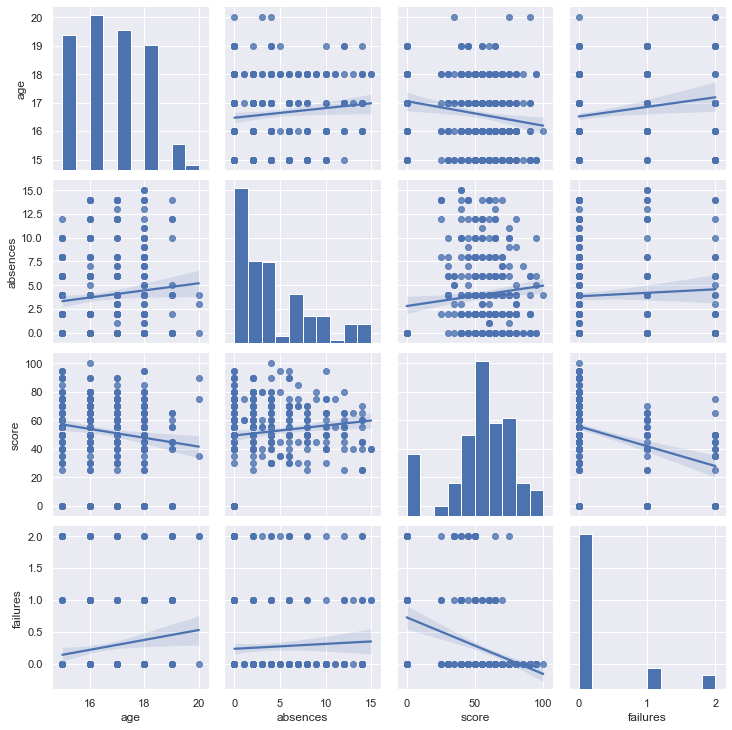

In [164]:
# Проналазируем исходные данные
sns.pairplot(stud[(stud['absences_flag'] == 'primary')&(stud['score_flag'] == True)][['age', 'absences', 'score', 'failures']], kind='reg')

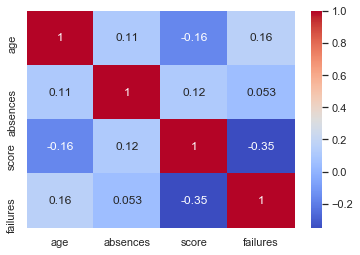

In [165]:
#Используем для наглядности матрицу корреляций численных показателей, состоящих из исходных данных:
stud_corr = stud[(stud['absences_flag'] == 'primary')&(stud['score_flag'] == True)][['age', 'absences', 'score', 'failures']].corr()
sns.heatmap(stud_corr, annot=True, cmap= 'coolwarm')

Для сравнения с исходными данными без устранения выбросов, продублируем исходный датафрейм и проведём корреляционный анализ для него

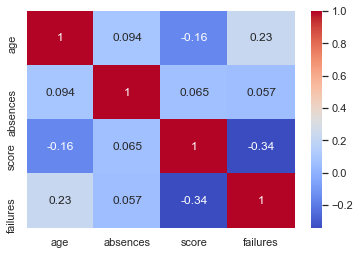

In [166]:
prim_stud = pd.read_csv('stud_math.csv')
prim_stud.columns = ['school', 'sex', 'age', 'adress', 'famsize', 'p_status', 'm_edu', 'f_edu',
                'm_job', 'f_job', 'reason', 'guardian', 'traveltime', 'studytime',
                'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
                'freetime', 'goout', 'health_level', 'absences', 'score']

#Используем для наглядности матрицу корреляций численных показателей, состоящих из исходных данных:
prim_stud_corr = prim_stud[['age', 'absences', 'score', 'failures']].corr()
sns.heatmap(prim_stud_corr, annot=True, cmap= 'coolwarm')

**Вывод по корреляционному анализу:**
- значения **"age"**, **"absences"** и **"absences"**, **"failures"** **очень слабо** (до 0.2) коррелируют друг с другом, в связи с чем исключить какую-либо колонку в этих парах как дублирующие другую не получится. При этом в исходном датафрейме имеется **слабая** (до 0.5) корреляция между **"age"** и **"failures"**;
- с показателем **"score"** сильнее всего коррелирует *(с обратной зависимостью)* показатель неудач **"failures"** (однако ниже он будет рассматриваться как ранговый признак). Такую корреляцию (до 0.5) можно назвать **слабой**;
- имеется также **очень слабая** (до 0.2) корреляция показателя **"score"** с возрастом **"age"** (обратная зависимость) и с количеством пропущенных занятий **"absences"** (была **0.065** до устранения выбросов), причем последняя колонка, как ни странно, имеет положительную корреляцию с **"score"**. Первая взаимосвязь из них 

Для модели рекомендуется оставить колонку **"failures"**, как имеющую наиболее сильную из рассмотренных взаимосвязь с "score".
В первом приближении также можно оставить и колонку **"age"**.

## Анализ категориальных переменных

Анализ категориальных переменных проводится для **ранговых** и **категориальных** колонок.

К **ранговым переменным** относятся: **"m_edu"**, **"f_edu"**, **"m_job"**, **"f_job"**, **"traveltime"**, **"studytime"**, **"failures"** *(пояснение по ней выше)*, **"famrel"**, **"freetime"**, **"goout"**, **"health_level"**, а также созданные на базе числовых:  **"age_categ"**, **"absences_categ"**, **"score_categ"**

К **категориальным переменным** относятся: **"school"**, **"sex"**, **"address"**, **"famsize"**, **"p_status"**, **"reason"**, **"guardian"** **"schoolsup"**, **"famsup"**, **"paid"**, **"activities"**, **"nursery"** **"higher"**, **"internet"**, **"romantic"**.

Имеются также созданные **служебные колонки** для отделения исходных данных от заполненных:  **"absences_flag"**, **"score_flag"**


### Построение графической зависимости (Boxplot)
Оценим влияние значения категориального показателя на целевой параметр **"score"**

In [167]:
# Функция построения boxplot-графиков для значений изучаемой колонки
def get_boxplot(column):
    #Создание объекта fig с возможностью разместить несколько графиков
    fig, axes = plt.subplots(figsize=(10,4))
    # Построение "ящиков с усами"
    sns.boxplot(x=column, y='score', data=stud, ax=axes)
    # Настройка вывода графиков
    plt.xticks(rotation=0)
    axes.set_title(column + ' boxplot')

In [168]:
col_list = list(stud.columns)
for col in ['age', 'absences', 'score', 'score_categ', 'absences_flag', 'score_flag']:
    col_list.remove(col)

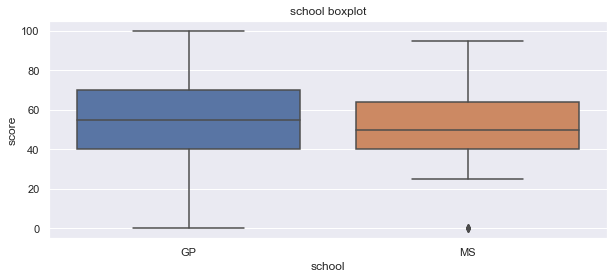

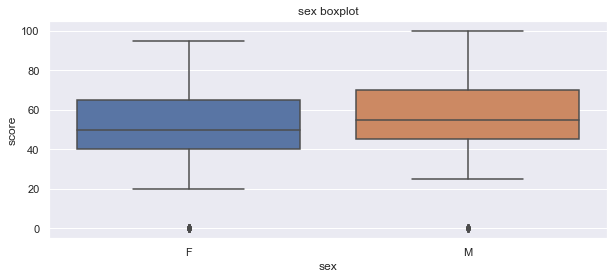

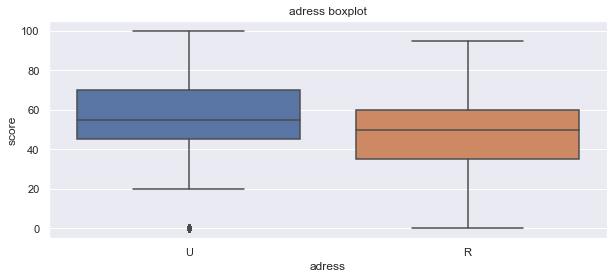

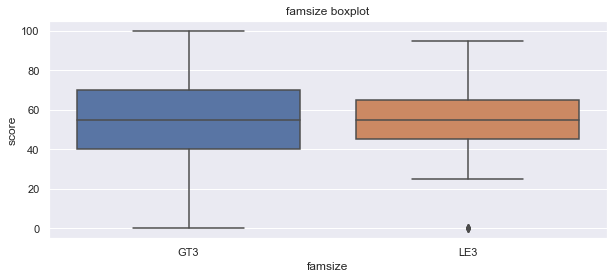

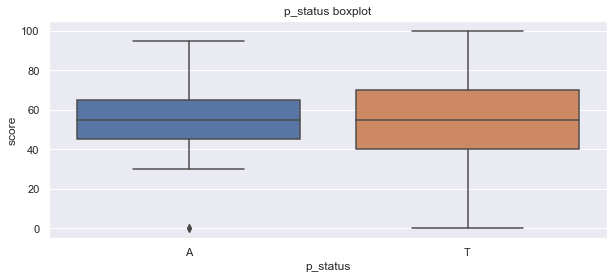

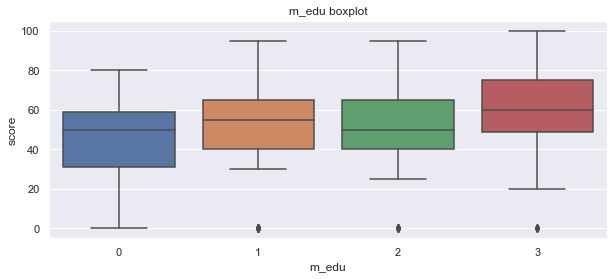

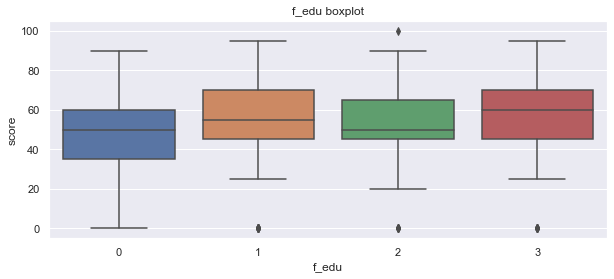

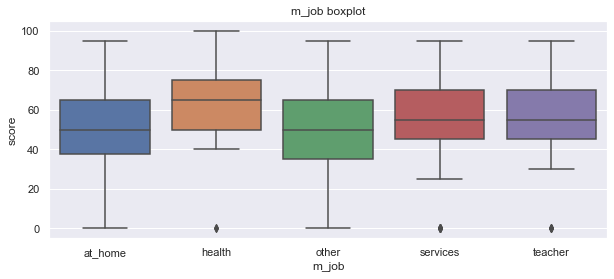

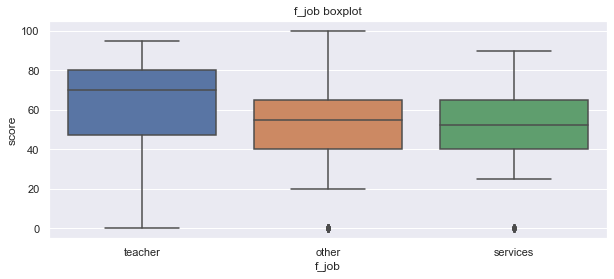

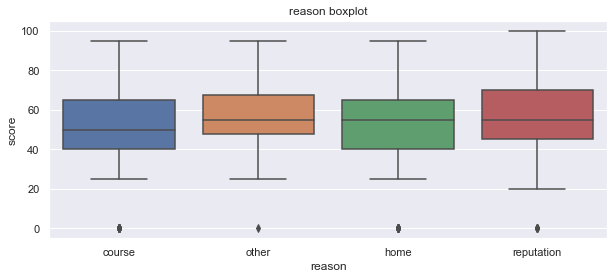

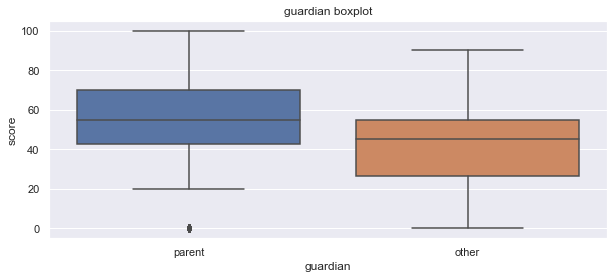

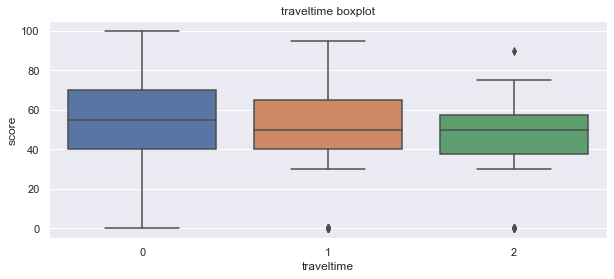

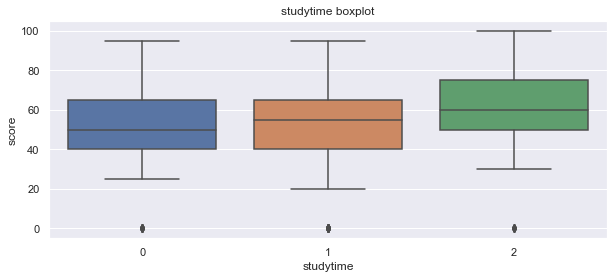

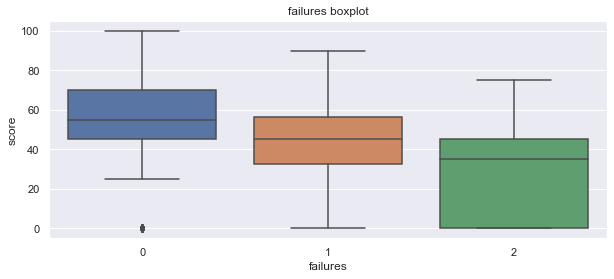

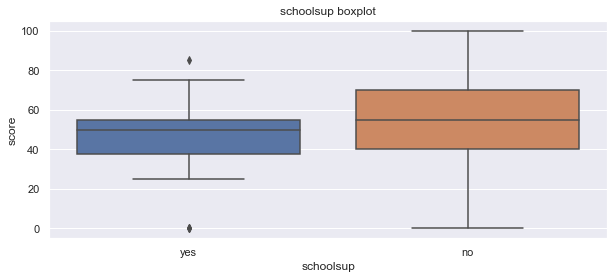

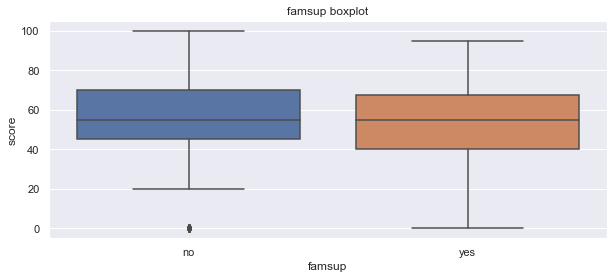

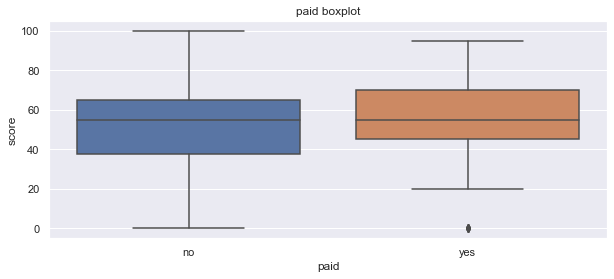

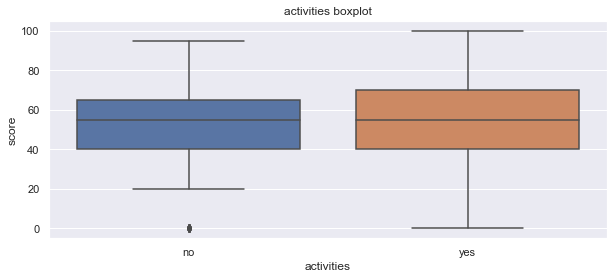

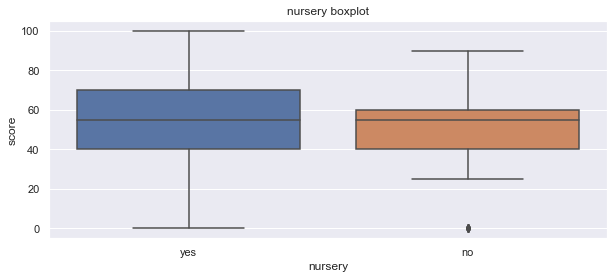

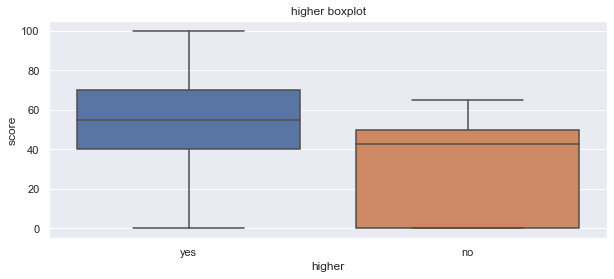

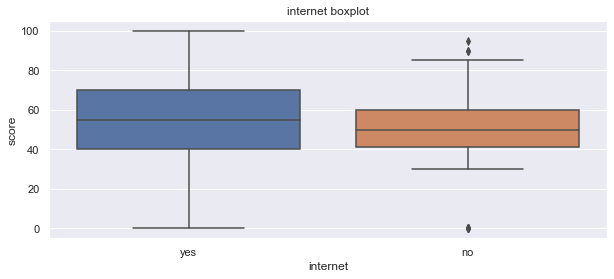

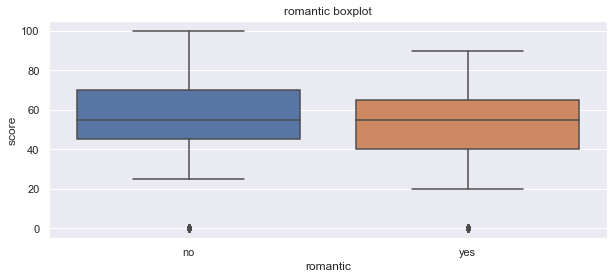

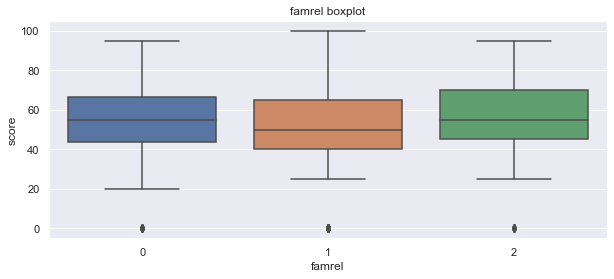

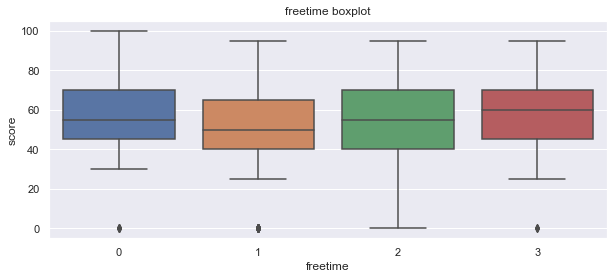

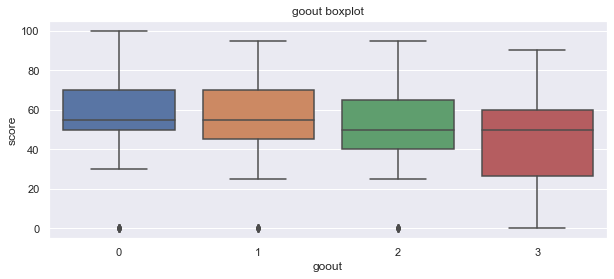

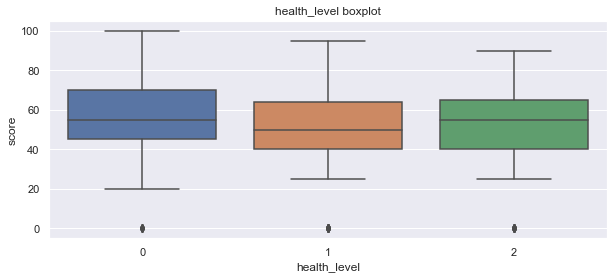

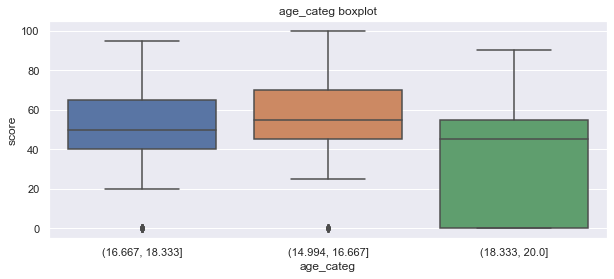

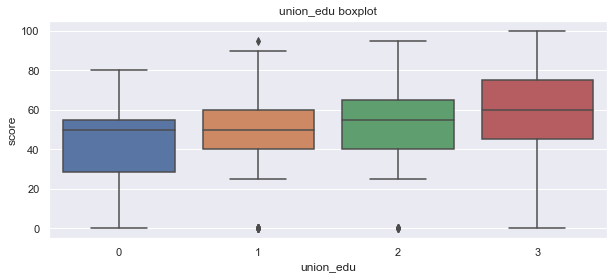

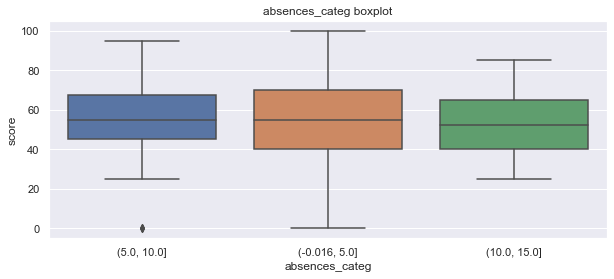

In [169]:
# Построим boxplot для интересующих колонок
for col in col_list:
    get_boxplot(col)

**Вывод по графическому анализу категориальных переменных**.

Следующие колонки имеют визуальное различие в распределении баллов по математике в зависимости от значения колонки: 
**"sex"**, **"adress"**, **"union_edu"** (**"m_edu"**, **"f_edu"**), **"m_job"**, **"f_job"** *(teacher)*, **"f_job"**, **"guardian"**, **"traveltime"**, **"studytime"**, **"failures"**, **"higher"** *(но малая выборка со значением "no")*, **"internet"**, **"goout"**, **"f_job"** 

### Тестирование гипотезы о разности средних
Проверим, есть ли статистическая разница в распределении баллов по категориальным признакам, с помощью теста Стьюдента. 

Проверим **нулевую гипотезу** о том, что распределения баллов по различным параметрам неразличимы:

Категориальные колонки, влияющие на переменную **"score"**:

In [170]:
stat_dif_lt = []
for alph in [0.01, 0.05, 0.1]:    
    for col in col_list:
        stat_dif_lt.append(mod_eda.get_stat_dif(stud, 'score', col, alpha=alph))
all_stat_df = pd.DataFrame(stat_dif_lt)
stat_df = all_stat_df[all_stat_df['differ']].drop_duplicates('column')
stat_df.sort_values(['alpha', 'p_val'])

column  differ  alpha     p_val
13   failures    True   0.01  0.000002
5       m_edu    True   0.01  0.000637
27  union_edu    True   0.01  0.000712
10   guardian    True   0.01  0.002427
35      f_edu    True   0.05  0.002073
36      m_job    True   0.05  0.002638
53      goout    True   0.05  0.004910
41  studytime    True   0.05  0.010498
55  age_categ    True   0.05  0.013791
50   romantic    True   0.05  0.025599
45       paid    True   0.05  0.036130
30        sex    True   0.05  0.038257
31     adress    True   0.05  0.040812
66      f_job    True   0.10  0.030921
72  schoolsup    True   0.10  0.055828
61    famsize    True   0.10  0.081735

# Итог

На основе проведённого тестирования гипотез о разности средних были выбраны следующие колонки, влияющие на переменную **"score"**: 
- **"failures"**, **"union_edu"**, **"guardian"**; 
- **"m_job"**, **"goout"**, **"studytime"**, **"romantic"**, **"paid"**, **"sex"**, **"adress"**;

Вместе с отобранной числовой колонкой **"age"** *максимальное количество* рекомендуемых колонок (не считая **score**) составляет **11**

Составим на их основе **новый датафрейм**:

In [172]:
new_stud = stud[['age', 'failures', 'union_edu', 'guardian', 'm_job', 'goout', 'studytime', 'romantic', 'paid', 'sex', 'adress', 'score']]
new_stud.info()
new_stud.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        395 non-null    int64  
 1   failures   395 non-null    int32  
 2   union_edu  395 non-null    int64  
 3   guardian   395 non-null    object 
 4   m_job      395 non-null    object 
 5   goout      395 non-null    int32  
 6   studytime  395 non-null    int32  
 7   romantic   395 non-null    object 
 8   paid       395 non-null    object 
 9   sex        395 non-null    object 
 10  adress     395 non-null    object 
 11  score      395 non-null    float64
dtypes: float64(1), int32(3), int64(2), object(6)
memory usage: 32.5+ KB


age  failures  union_edu guardian    m_job  goout  studytime romantic paid  \
0   18         0          3   parent  at_home      2          1       no   no   
1   17         0          0   parent  at_home      1          1       no   no   
2   15         2          0   parent  at_home      0          1       no  yes   
3   15         0          3   parent   health      0          2      yes  yes   
4   16         0          2   parent    other      0          1       no  yes   

  sex adress  score  
0   F      U   30.0  
1   F      U   30.0  
2   F      U   50.0  
3   F      U   75.0  
4   F      U   50.0

### Состав нового датфрейма:

- **age** — возраст ученика (от 15 до 20). Значение 20 вбирает в себя от 20 лет;

- **failures** — количество неудач (от 0 до 2), предположительно речь о других сдаваемых экзаменах;

- **union_edu** — агрегированная колонка образования матери *(приоритетнее с точки зрения влияния на показатель "score")* и отца. Уровень среднего семейного образования от **0** - низкий (уровень начальной школы) до **3** - высокий (ВУЗ).

- **guardian** — опекун (**'parent'** - мать/отец, **'other'** - другое);

- **m_job** — работа матери (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

- **goout** — проведение времени с друзьями (от **0** - мало до **3** - очень много);

- **studytime** — время на учёбу помимо школы в неделю (**0** - <2 часов, **1** - 2-5 часов, 
    **2** - 5-10 часов и больше);

- **romantic** — в романтических отношениях (**yes** или **no**);

- **paid** — дополнительные платные занятия по математике (**yes** или **no**);

- **sex** — пол ученика (**'F'** - женский, **'M'** - мужской);

- **address** — тип адреса ученика (**'U'** - городской, **'R'** - за городом);

- **score** - баллы по госэкзамену по математике (целевой параметр).

Столбцы в новом датафрейме расположены в порядке **возрастания уровня значимости**, в связи с чем, если необходимо сократить число колонок, убирать необходимо колонки справа налево (без учёта параметра **score**). 5 %-ный уровень значимости заканчивается на колонке **internet**.

К **самым важным** следует отнести: **"age"**, **"failures"**, **"union_edu"**, **"m_job"**, **"guardian"**

# Заключение

В ходе проведённого разведывательного анализа данных было **выполнено** следующее:
- проверено **качество** данных и произведена их **очистка** от _пропусков и выбросов_. Так, *пустых значений* в изучаемом датафрейме оказалось относительно немного (**не более 12%** в одной колонке). _Выбросы_ имелись только в колонках "age" (1) и "absences" (34). Возможно, имеют место скрытые пропуски в некоторых из колонках (см. выводы по разделу "Анализ данных в столбцах"). В итоге можно сказать, что данные **достаточно чистые**;

- **сформулированы предположения** для дальнейшего построения модели в виде выводов под каждой колонкой (см. выводы по разделу "Анализ данных в столбцах");

- **определены параметры модели**, оказывающие влияние на целевой показатель (успеваемость по математике) (см. "Итог").